# 1. Data Background and Problem Formulation

In this project, a dataset is given with 900+ data each corresponding to individual indicators of users' experience surveys revolving around proposed system designs -- and how would potential users react or perceive this notion. 

The goal is to provide a deep learning model with an acceptable rate of AUC (0.7 to 0.9) on test dataset in order to be able to predict certain words clearly.

To gain a better sense of the data, we first import the necessities to run the overall code.

---


In [ ]:
# Configure output settings to prettify print display
from IPython.display import HTML, display
def set_css():
    display(HTML('''
    <style>
    pre {
    white-space: pre-wrap;
    }
    </style>
    '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# Ignore warnings to prettify print

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# !pip install scikit-multilearn
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import imblearn

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1.1. Importing the data
We can then import the data via `pandas` package to see the overall nature of the data, the outputs, and the datatypes.

In [ ]:
df = pd.read_excel('Charis-avg3.xlsx',
                   sheet_name='avg3-round', header=[0], engine='openpyxl')
df.drop(columns=['ID', 'ProjectID', 'Class'], axis=1, inplace=True)
df.sample(n=10, random_state=1)

Requirements  ...  leading edge
718  Secure data transfer over the Internet could b...  ...             3
637  The system shall validate the amount is availa...  ...             3
759  Sensitive data will be encrypted before being ...  ...             3
366  PME Subsystem shall allow building product men...  ...             5
543  The system shall be responsive. At the DePaul ...  ...             4
41   The product shall synchronize with the office ...  ...             4
120  Program Administrators and Nursing Staff Membe...  ...             3
725  It must be able to download the most recent me...  ...             3
795  Customer must logout of the site after purchas...  ...             4
672  Changes made to the Manage My ID website can b...  ...             5

[10 rows x 9 columns]

## 1.2. Column Definitions
### 1.2.1. Features

Features are only represented in the first column, which is the `Requirements` column. This column represents the question and/or the funcionalities of the system itself.

### 1.2.2. Labels

Labels, on the other hand, comprised of 8 columns in total. They are:
* **obstructive<==>supportive**, measuring supportiveness.
* **complicated<==>easy**, measuring ease-of-use.
* **inefficient<==>efficient**, measuring efficiency.
* **confusing<==>clear**, measuring brevity and clarity.
* **boring<==>exciting**, measuring excitement.
* **not interesting<==>interesting**, measuring appeal.
* **conventional<==>inventive**, measuring innovation.
* **usual<==>leading edge**, measuring technology usage.

The scales on the labels vary from 1 to 7, in which values closer to 1 corresponds to a more negative connotation, while values closer to 7 is likely to be more positive.

For example, for column `boring<==>exciting`, if a user gives it a 3, whilst this may seem neutral at first glance, we can infer that the user does not regard this system design as easy-to-use -- otherwise they would give it a score of 5 or 6.

For this task, we'll run multiclass multilabel regression since we obtained a good AUC with multiclass regression on one column before with simple regression. **The trick here is to not use a single column.**

With this, we might want to approach the problem within the scope of [Multi-output Regression](https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/)

First, we separate the labels from the data.

In [ ]:
features = df.iloc[:, 0].values  # First column in the entire set
labels = df.iloc[:, np.r_[1:9]].values
print("Features is now of type:", type(features), "with shape", features.shape)
print("Labels is now of type:", type(labels), "with shape", labels.shape)

Features is now of type: <class 'numpy.ndarray'> with shape (969,)
Labels is now of type: <class 'numpy.ndarray'> with shape (969, 8)


We know from previous work that the dataset is very much imbalanced, so we would want to try oversampling across all columns and make them our new label. But first, we would want to convert features as word vectors first.

## 1.3. Quick EDA

We can visualize the most used words via `wordcloud` used in our dataset.

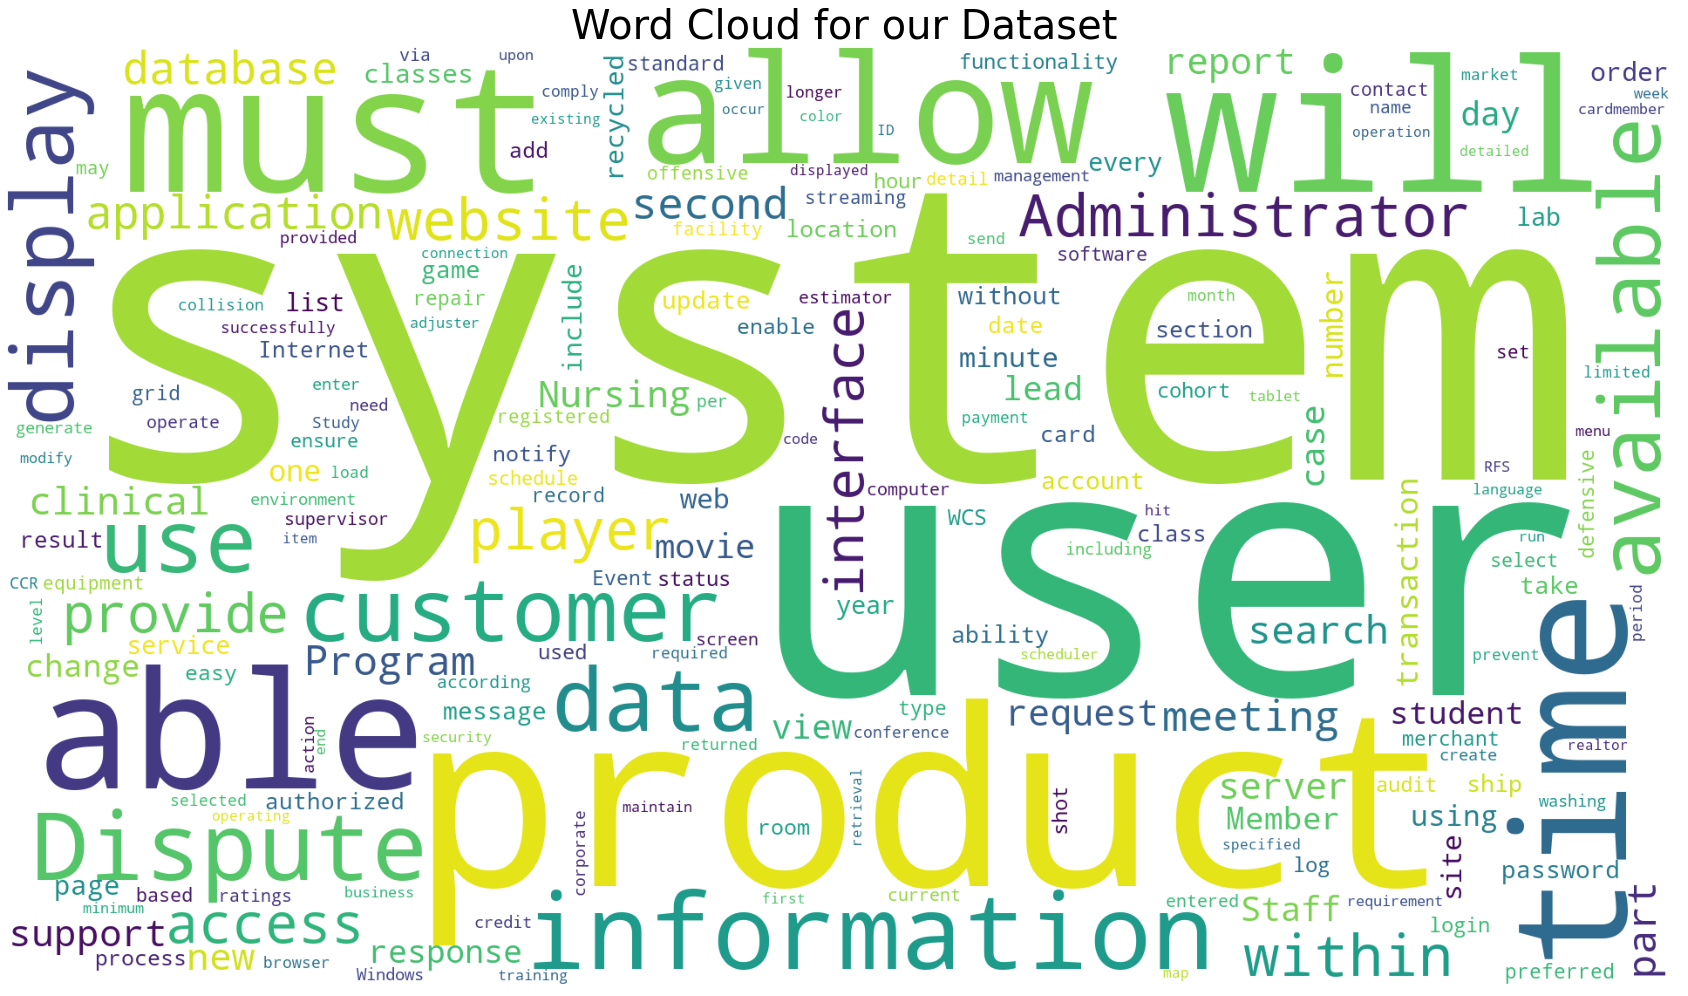

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(30,20))
text =df['Requirements'].values
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1920,
                          height=1080
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Word Cloud for our Dataset",fontsize=40)
plt.imshow(cloud)

In [ ]:
from collections import Counter
for i in range(8):
    print("Column:", df.columns[1:][i])
    print(Counter(labels[:, i]))

Column: supportive
Counter({6: 476, 7: 272, 5: 173, 4: 41, 3: 6, 2: 1})
Column: easy
Counter({6: 491, 5: 295, 7: 90, 4: 81, 3: 10, 2: 2})
Column: efficient
Counter({6: 546, 7: 251, 5: 140, 4: 28, 3: 4})
Column: clear
Counter({6: 490, 7: 242, 5: 200, 4: 32, 3: 4, 2: 1})
Column: exciting
Counter({4: 465, 5: 313, 3: 106, 6: 76, 7: 5, 2: 4})
Column: interesting
Counter({4: 406, 5: 387, 3: 96, 6: 73, 7: 5, 2: 2})
Column: inventive
Counter({4: 438, 3: 316, 5: 124, 2: 72, 6: 14, 1: 5})
Column: leading edge
Counter({4: 428, 3: 312, 5: 147, 2: 60, 6: 16, 1: 6})


# 2. Pre-processing
---

## 2.1. Tokenization

Tokenization means splitting each word and vectorizing a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary). This process cleans up our text, lowercase, and remove punctuations. This step is basically the same from our previous work involving LSTMs.

This way, we can see which words appear the most in our training set.

In [ ]:
tokenizer = Tokenizer(num_words=2000, oov_token="<OOV>")
tokenizer.fit_on_texts(features)
word_index = tokenizer.word_index
dict(list(word_index.items())[:10])

{'<OOV>': 1,
 'a': 8,
 'and': 9,
 'be': 7,
 'of': 6,
 'product': 10,
 'shall': 3,
 'system': 5,
 'the': 2,
 'to': 4}

After tokenization, the next step is to turn those tokens into lists of sequence.

In [ ]:
sequences = tokenizer.texts_to_sequences(features)
print(sequences[0])
# This corresponds to the first sentence in the training data.

[2, 5, 3, 672, 2, 32, 95, 673, 49]


## 2.2. Padding

When we train neural networks for NLP, we need sequences to be in the same size, that's why we use padding. Padding means that we convert all instances of the training data towards the same size. To do this, we need to specify a fixed length to transform all the instances on.

For the project, we can set the sequence by looking quickly at the average proportion of the training words.

In [ ]:
import math
word_counts = []
for i in (features):
    word_counts.append(len(i.split(" ")))
print("Average word counts:", sum(word_counts)/len(word_counts))

# Round max length of padding to the nearest tenth
max_length = math.ceil((sum(word_counts)/len(word_counts))/10) * 10
print("Padded onto length: ", max_length)

# Delete unused variable
del word_counts

Average word counts: 18.223942208462333
Padded onto length:  20




We can then proceed to do the actual padding. This is done for all instances of the training example.

In [ ]:
padded = pad_sequences(sequences, maxlen=max_length,
                       padding='post', truncating='post')

for i in range(5):
    print("Sequence of length", len(sequences[i]),
          "was padded onto", len(padded[i]))

Sequence of length 9 was padded onto 20
Sequence of length 16 was padded onto 20
Sequence of length 29 was padded onto 20
Sequence of length 36 was padded onto 20
Sequence of length 35 was padded onto 20


## 2.3. ROS Oversampling

Generally, oversampling makes fake data so that the minority labels are not squashed by the majority.

Constraint of using SMOTE within this dataset is that it's very fragile to classes with only one example. Since SMOTE works via k-nearest neighbors, at least two members of a class would be mandatory for it to work. For this project, we're going to use ROS.

ROS generates random data as opposed to the better, more superior SMOTE which generates "more credible" data. We can't use SMOTE on all sheets because of the `n_neighbors` and distance constraint.

We find the least common multiple of all class members amount, and oversample from there to get the matrix dimensions uniform.

Synthetic samples generated with respect to the most amount of classes in all columns so that input shape (features and labels) are consistent against each other.



In [ ]:
import copy
from collections import defaultdict, Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
max_amount = np.lcm.reduce([1, 2, 3, 4, 5, 6, 7]) * 40
labels_processed = np.zeros((max_amount, 8))

for i in range(8):
    unique_classes = np.unique(df[df.columns[1:][i]])
    amount = [int(
        (max_amount/len(unique_classes)))
        ] * len(unique_classes)
    x = {k:v for (k,v) in zip(unique_classes, amount)}
    smt = RandomOverSampler(sampling_strategy=x)
    X, y = smt.fit_resample(padded, labels[:,i])
    labels_processed[:,i] = y
    print("Column", i, "done.")
    # We don't save nor use the X variable between each iteration, 
    # instead only using the last one.


print("Shape of input features is:", X.shape) # 20 words represented on 20 columns
print("Shape of labels is:",labels_processed.shape) # 8 different classes on 8 columns

Column 0 done.
Column 1 done.
Column 2 done.
Column 3 done.
Column 4 done.
Column 5 done.
Column 6 done.
Column 7 done.
Shape of input features is: (16800, 20)
Shape of labels is: (16800, 8)


In [ ]:
# Sanity check time!
for i in range(8):
    print("For column", df.columns[1:][i])
    print(Counter(labels_processed[:, i]), "\n------")


print("First ten entries of the processed labels:\n", labels_processed[:10, :])
print("First ten entries of the processed features:\n", X[:10, :])

# Last and final assertion to catch matrix errors
try:
    assert(X.shape[0] == labels_processed.shape[0])
    print("Assertion completed!")
except AssertionError:
    print("Error!\nShape of X is", X.shape,
          "while labels is", labels_processed.shape)
    raise AssertionError

For column supportive
Counter({4.0: 2800, 6.0: 2800, 7.0: 2800, 5.0: 2800, 2.0: 2800, 3.0: 2800}) 
------
For column easy
Counter({4.0: 2800, 5.0: 2800, 3.0: 2800, 6.0: 2800, 7.0: 2800, 2.0: 2800}) 
------
For column efficient
Counter({4.0: 3360, 5.0: 3360, 6.0: 3360, 3.0: 3360, 7.0: 3360}) 
------
For column clear
Counter({3.0: 2800, 6.0: 2800, 7.0: 2800, 4.0: 2800, 5.0: 2800, 2.0: 2800}) 
------
For column exciting
Counter({4.0: 2800, 3.0: 2800, 5.0: 2800, 6.0: 2800, 7.0: 2800, 2.0: 2800}) 
------
For column interesting
Counter({4.0: 2800, 3.0: 2800, 5.0: 2800, 6.0: 2800, 2.0: 2800, 7.0: 2800}) 
------
For column inventive
Counter({4.0: 2800, 3.0: 2800, 2.0: 2800, 5.0: 2800, 6.0: 2800, 1.0: 2800}) 
------
For column leading edge
Counter({4.0: 2800, 3.0: 2800, 5.0: 2800, 2.0: 2800, 6.0: 2800, 1.0: 2800}) 
------
First ten entries of the processed labels:
 [[4. 4. 4. 3. 4. 4. 4. 4.]
 [6. 4. 5. 6. 4. 4. 3. 4.]
 [7. 5. 6. 7. 4. 4. 4. 4.]
 [5. 3. 4. 4. 3. 3. 3. 3.]
 [6. 4. 6. 7. 5. 5. 3. 

## 2.4. Train-test Splitting

Finally we get to this part. We can use sklearn's `train_test_split` to do the usual splitting for test set (validation set is specified within building the model in the next section).

Also, specifying `random_state` ensures reproducibility.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, labels_processed, test_size=0.2, random_state=42)

# Sanity check again and again
print("Training examples:", X_train.shape)
print("Training labels:", y_train.shape)
print("Test examples:", X_test.shape)
print("Test labels:", y_test.shape)

Training examples: (13440, 20)
Training labels: (13440, 8)
Test examples: (3360, 20)
Test labels: (3360, 8)


# 3. Modelling

## 3.1. Building the Model

Since we're training on augmented data, we're going to approach this as conventional regression compared to the LSTM approach we're doing it before.

LSTM model in this manner would result in a pretty bad metric score (around 0.5 to 0.7 F1-score) whereas our fully-connected dense layers resulted in a pretty satisfying F1, which is around 0.8 to 1 for each column.

In [ ]:
# Wrapper functions for result interpretation
from matplotlib import pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def transform_results(estimates):
    res = []
    for x in estimates:
        if x > 7:
            x = 7
            res.append(x)
        elif x < 0:
            x = 0
            res.append(x)
        else:
            res.append(x)
    return res

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
initializer = tf.keras.initializers.RandomNormal(seed=1)  # Reproducibility

model = Sequential(name="classifier_NN")
model.add(tf.keras.Input(shape=(X_train.shape[1],)))
# Automatically detect features as input nodes
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
# model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
# model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(8))  # output layer
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'], optimizer=opt)
model.summary()

Model: "classifier_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)             

Epoch 1/150
294/294 [==============================] - 4s 6ms/step - loss: 3.6967 - mae: 1.4628 - val_loss: 2.0927 - val_mae: 1.1289
Epoch 2/150
294/294 [==============================] - 2s 5ms/step - loss: 1.4785 - mae: 0.9073 - val_loss: 1.0444 - val_mae: 0.7746
Epoch 3/150
294/294 [==============================] - 2s 5ms/step - loss: 0.7985 - mae: 0.6681 - val_loss: 0.4674 - val_mae: 0.4950
Epoch 4/150
294/294 [==============================] - 2s 5ms/step - loss: 0.6082 - mae: 0.5784 - val_loss: 0.3572 - val_mae: 0.4350
Epoch 5/150
294/294 [==============================] - 2s 5ms/step - loss: 0.5199 - mae: 0.5281 - val_loss: 0.3091 - val_mae: 0.3936
Epoch 6/150
294/294 [==============================] - 2s 5ms/step - loss: 0.4663 - mae: 0.4959 - val_loss: 0.4037 - val_mae: 0.4666
Epoch 7/150
294/294 [==============================] - 2s 5ms/step - loss: 0.4585 - mae: 0.4872 - val_loss: 0.3016 - val_mae: 0.3911
Epoch 8/150
294/294 [==============================] - 2s 5ms/step - 

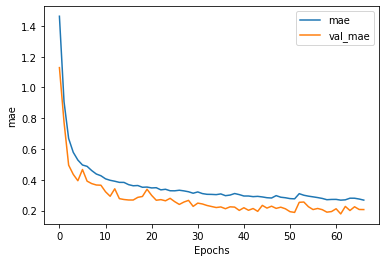

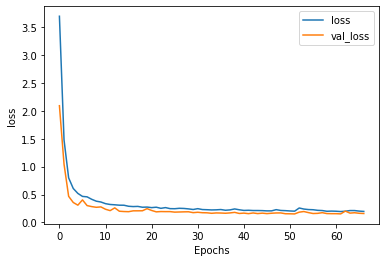

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(
    X_train, y_train, epochs=150, batch_size=32,
    validation_split=0.3,
    callbacks=[es],
    verbose=1)

plot_graphs(history, "mae")
plot_graphs(history, "loss")

## 3.2. Result Interpretation and Evaluation

Here we evaluate on `y_test`, which we made sure earlier comes from a similar distribution within the training set itself. 

Resulted on a pretty confident `mae` and `mse`, which I would say a good result considering the number of classes we have.

In [ ]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 11s 3ms/step - loss: 0.1553 - mae: 0.2034
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 15.53%
mae: 20.34%


## 3.3. Prepare the Plotting Set

Due to the multi-dimensional nature of our results and test set, we need to reshape the predictions by using `numpy`'s `flatten()` attribute, which flattens the array column-wise if we specify the argument `order='F'` to flatten in Fortran-style order.

Keep in mind this will indeed aggregate the metrics like on the `classification_report()` below.

After that, we're rounding the result to the nearest integer -- because we're tackling this originally as a regression task. For example, if a prediction is `4.7`, it will be rounded to `5`, and therefore will be predicted as class no. 5. 

Multi-class ordinal classification cannot be implemented with standard fully-connected layer. And implementing multi-headed layers are outside the scope of this project.

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_flattened = y_pred.flatten(order='F')
y_test_flattened = y_test.flatten(order='F')
y_classified = ([round(float(x)) for x in y_pred_flattened]) 

print("First ten examples of the test set:")
print("Truth labels:", y_test_flattened[:10])
print("Predicted labels:", y_classified[:10])
print("Overall performance on all columns:\n",
      classification_report(y_classified, y_test_flattened))

First ten examples of the test set:
Truth labels: [3. 2. 3. 2. 5. 4. 4. 4. 4. 7.]
Predicted labels: [3, 2, 3, 2, 5, 4, 4, 4, 4, 2]
Overall performance on all columns:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      1088
           2       0.99      0.99      0.99      3870
           3       0.93      0.95      0.94      4601
           4       0.81      0.85      0.83      4562
           5       0.84      0.77      0.81      5104
           6       0.86      0.85      0.86      4415
           7       0.93      0.95      0.94      3240

    accuracy                           0.89     26880
   macro avg       0.91      0.91      0.91     26880
weighted avg       0.89      0.89      0.89     26880



In [ ]:
# Wrapper function(s) from earlier notebook
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

avgroc = dict()


def plot_multiclass_roc_avg(fpr, tpr, n_classes, figsize=(17, 6)):
    roc_auc = dict() # Initialize empty dictionary to store scores
    target_names = [1, 2, 3, 4, 5, 6, 7] # Target names to predict
    for i in range(n_classes): # Loop over the number of classes
        roc_auc[i] = auc(fpr[i], tpr[i]) # Calculate AUC with respect to false and true positive rate

    # Initialize empty figure to render our plots on
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')

    # Render each AUC curve, 1 for each class
    for i in range(len(target_names)):
        ax.plot(fpr[i], tpr[i],
                label='ROC curve (area = %0.2f) for %s' % (roc_auc[i],
                                                           target_names[i]))

    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()


def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    """
    Modified function behavior, now predicts column-wise
    """
    y_score = clf.predict_proba(X_test)
    target_names = np.unique(y_test)
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    # print(y_test_dummies.shape, y_score.shape) # Uncomment to debug and see shapes (we feared an input mismatch)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i]) # Get the true and positive rate for each class prediction(s)
        roc_auc[i] = auc(fpr[i], tpr[i]) #  Calculate AUC with respect to false and true positive rate

    # Render each AUC curve, 1 for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')

    for i in range(len(target_names)):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s'
                % (roc_auc[i], target_names[i]))

    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

    return fpr, tpr


def plot_multiclass_roc_LSTM(X_test, y_test,
                             n_classes, figsize=(17, 6), model=model):
    """
    Custom-made function to plot ROC curve.
    Sorry I can't run because I don't have the
    excel file used for this particular notebook.
    """
    y_score = to_categorical(y_test)
    target_names = ["obstructive vs supportive",
                    "complicated vs easy", "inefficient vs efficient",
                    " confusing vs clear", "boring vs exciting",
                    "not interesting vs interesting",
                    "conventional vs inventive", "usual vs leading edge"] # Initialize target names 
                                                                          # (from original data)
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # One-liner transformation of our existing result.
    # This reshapes our input from ordinal to categorical (one-hot encoded)
    # and pads the input with zeroes to handle input mismatch.
    y_test_dummies = np.pad(
        pd.get_dummies(y_classified, drop_first=False).values, 
        ((0, 0), (min(labels.flatten()), 0)))
    # print(y_test_dummies.shape, y_score.shape)
    # Quick debug purposes after one-hot encoding. It can go wrong in so many ways.
    # Mainly done to ensure matrix dimension is right.
    for i in range(1, n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Render each AUC curve, 1 for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Column-wise Receiver Operating Characteristic Plot')

    for i in range(1, len(target_names)):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s'
                % (roc_auc[i], target_names[i]))

    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

ROC AUC score: 0.9358068899750152


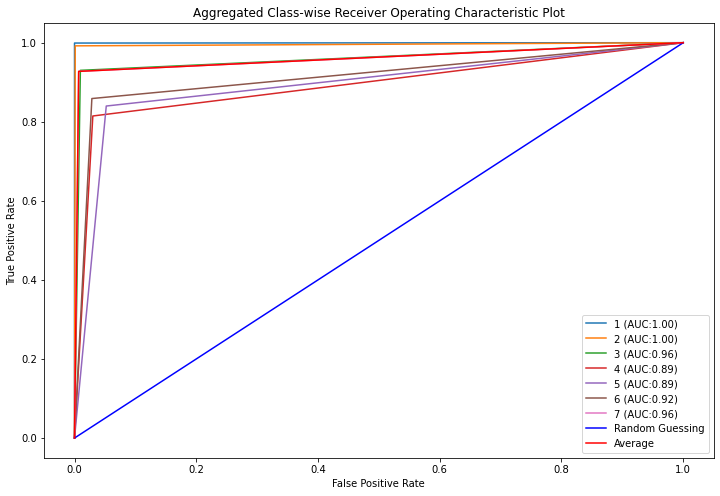

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Function to compute area under curve.
# AUC is computed via binary one-vs-all situation.
def score_auc(y_test, y_pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)


fig, c_ax = plt.subplots(1, 1, figsize=(12, 8))

# Function to compute area under curve, but for multi-class (not multi-label)
# AUC is computed via binary one-vs-all situation.
def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(set(labels.flatten())):
        fpr, tpr, thresholds = roc_curve(
            y_test[:, idx].astype(int), y_pred[:, idx])
        c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label='Random Guessing')
    c_ax.plot(fpr, tpr, 'r-', label='Average')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:',
      multiclass_roc_auc_score(y_test_flattened, y_classified))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('Aggregated Class-wise Receiver Operating Characteristic Plot')
plt.savefig("auc.png")
plt.show()

### 3.3.1. List Initialization
After plotting the ROC curve, we can initialize some empty list to keep track of the evaluation metrics we're going to use.

In [ ]:
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from operator import add
acc = []
pre = []
recall = []
f1 = []
rms = []
aucscore = []
mae = []

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score
from sklearn.metrics import recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, recall_score
from sklearn.metrics import mean_absolute_error

# making an empty DataFrame to log results
data = {'metric':['Accuracy', 'Precision', 'Recall', 'F1 Score','RMSE','AUC score', 'MAE']}
metric_df = pd.DataFrame(data).set_index(['metric'])
# metric_df # Uncomment metric_df to take a preview of the dataframe.

We can also print classification report from each column, and append each resulting evaluation metric to the existing list we initialized.

In [ ]:
y_pred = model.predict(X_test)
for i in range(8): # Loop over columns
    print("Column", df.columns[1:][i]) # Print which column we're analyzing

    # Rounding the predictions because we're approaching a problem as a regression task
    # despite we have 7 output nodes. This way, regression outputs, which would be continuous,
    # are seen as classes instead.
    estimates = [round(float(x)) for x in y_pred[:, i]] 
    estimates = transform_results(estimates)

    # print(np.unique(estimates)) # Uncomment to see the unique classes in that column
    print(classification_report(y_test[:, i], estimates), "\n------") # Print classification report

    # Append all the scores to our previously initialized list
    acc.append(accuracy_score(y_test[:, i], estimates))
    pre.append(precision_score(y_test[:, i], estimates, average='weighted'))
    recall.append(recall_score(y_test[:, i], estimates, average='weighted'))
    f1.append(f1_score(y_test[:, i], estimates, average='weighted'))
    rms.append(np.sqrt(mean_squared_error(y_test[:, i], estimates)))
    aucscore.append(score_auc(y_test[:, i], estimates))
    mae.append(mean_absolute_error(y_test[:, i], estimates))

Column supportive
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.97      0.96      0.97       576
         4.0       0.85      0.80      0.82       594
         5.0       0.69      0.72      0.71       571
         6.0       0.73      0.74      0.74       541
         7.0       0.89      0.90      0.90       534

    accuracy                           0.85      3360
   macro avg       0.86      0.85      0.86      3360
weighted avg       0.86      0.85      0.85      3360
 
------
Column easy
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.97      0.96      0.97       575
         4.0       0.85      0.82      0.84       589
         5.0       0.74      0.76      0.75       573
         6.0       0.80      0.82      0.81       541
         7.0       0.96      0.97      0.96       538

    accuracy                           

Here we display the average of each evaluation metric by calling `np.mean()` on each array -- remember, each array is comprised of multiple evaluation metrics; one for each column. 

In [ ]:
# Printing every classification metric
print("Average Accuracy : {}".format(np.mean(acc)))
print("Average Precision : {}".format(np.mean(pre)))
print("Average Recall : {}".format(np.mean(recall)))
print("Average F1-score : {}".format(np.mean(f1)))
print("Average RMSE-score : {}".format(np.mean(rms)))
print("Average MAE : {}".format(np.mean(mae)))
print("Average AUC-score : {}".format(np.mean(aucscore)))
metric_df['Neural Network Classifier'] = [
    np.mean(acc), np.mean(pre), np.mean(recall), np.mean(f1),
    np.mean(rms), np.mean(aucscore), np.mean(mae)]

Average Accuracy : 0.8934523809523809
Average Precision : 0.8975077117271504
Average Recall : 0.8934523809523809
Average F1-score : 0.8940450224613606
Average RMSE-score : 0.38376328122233827
Average MAE : 0.12269345238095238
Average AUC-score : 0.9351214174575726


## 3.4. Exporting the Model

We can export the model to `HDF5` format designed to store large amounts of information. More info:
* [Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_Data_Format)
* [TensorFlow Documentation](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format)

In [ ]:
model.save('UX_Regression.h5')

Our `metric_df` now looks like this for one single method. Note that we're trying to look for the best methods; so let's continue working.

In [ ]:
metric_df

Neural Network Classifier
metric                              
Accuracy                    0.893452
Precision                   0.897508
Recall                      0.893452
F1 Score                    0.894045
RMSE                        0.383763
AUC score                   0.935121
MAE                         0.122693

## 3.5. XGB Method
For comparison, we try implementing XGB.

In [ ]:
ffpo = dict(), dict()
temp = []
from scipy import interp # Interpolation package
target_label_names = ["obstructive vs supportive",
                      "complicated vs easy",
                      "inefficient vs efficient",
                      " confusing vs clear",
                      "boring vs exciting",
                      "not interesting vs interesting",
                      "conventional vs inventive",
                      "usual vs leading edge"]


def plot_multiclass_roc_optim(clf, X_train,
                              y_train, X_test, y_test, figsize=(17, 6)):
    """
    Modified function behavior, now predicts column-wise
    """
    # y_score = clf.predict_proba(X_test)
    target_names = np.unique(y_test)
    # structures
    fpr = dict()
    fprt = dict()
    tprt = dict()
    tpr = dict()
    roc_auc = dict()
    mean_tpr = dict()
    all_fpr = dict()
    # X_train, X_test, y_train[:,i], y_test[:,i],
    # calculate dummies once
    for j in range(8):
        # Again, this is to convert ordinal to categorical (one-hot encoded)
        y_test_dummies = pd.get_dummies(y_test[:, j], drop_first=False).values
        n_classes = y_test_dummies.shape[1]-1 # NumPy sees 9 classes -- because Python is zero-indexed

        # Loop over those 8 classes
        for i in range(n_classes):
            clf.fit(X_train, y_train[:, j]) # Fit the XGB model for that 1 class
            y_score = clf.predict_proba(X_test)
            fpr[i], tpr[i], _ = roc_curve(
                y_test_dummies[:, i], y_score[:, i]) # calculate ROC for that 1 class

        all_fpr[j] = np.unique(
            np.concatenate([fpr[i] for i in range(n_classes)]))

        mean_tpr[j] = np.zeros_like(all_fpr[j])
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
            mean_tpr[j] += interp(all_fpr[j], fpr[i], tpr[i])
        mean_tpr[j] /= n_classes
        fprt[j] = all_fpr[j]
        tprt[j] = mean_tpr[j]
        roc_auc[j] = auc(fprt[j], tprt[j])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')

    for j in range(8):
        ax.plot(fprt[j], tprt[j],
                label="ROC_curve Average of label {0} (area = {1:0.2f})"
                .format(target_label_names[j], roc_auc[j]))

    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

### 3.5.1. Classifier Wrapper Function

To provide brevity, we can define a wrapper so that we need to only invoke this function when we want to plot the resulting predictions across all different lea2rning algorithms. 

We need only to call this `plot_result_model()` function and pass in the specified keyword arguments to:
1. Make predictions on training features with `.fit()`.
2. Calculate corresponding evaluation metrics and save them to the lists initialized.
3. Plot multi-class ROC.

So, we can expect that this wrapper function will be used to infer the results across different learning algorithms.

Keep in mind that the function `plot_result_model()` will be again wrapped within `plot_all_result_model()` 

In [ ]:
ffpo = dict(), dict()
temp = []

def plot_result_model(clf, X_train, X_test, y_train, y_test,
             n_classes, ffpo, ttpo):
    clf.fit(X_train, y_train) # Fit our classifier `clf` of choice.
    # predictions over test set
    predictions = [round(float(x)) for x in clf.predict(X_test)] # Again, rounding the predictions 
                                                                 # because we're approaching a problem as a regression task
    print((classification_report(y_test, predictions))) # Print classification report
    
    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score.
    # In the end, we'll append them to our existing list to record.
    print('Confusion Matrix: \n', confusion_matrix(y_test, predictions))
    acc.append(accuracy_score(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    pre.append(precision_score(y_test, predictions, average='weighted'))
    print('Precision Score : ' + str(
        precision_score(y_test, predictions, average='weighted')))
    recal.append(recall_score(y_test,predictions, average='weighted'))
    print('Recall Score : ' + str(recall_score(
        y_test, predictions, average='weighted')))
    f1.append(f1_score(y_test, predictions, average='weighted'))
    print('F1 Score : ' + str(f1_score(
        y_test, predictions, average='weighted')))
    rms.append(np.sqrt(mean_squared_error(y_test, predictions)))
    aucscore.append(score_auc(y_test, predictions))
    mae.append(mean_absolute_error(y_test, predictions))
    fpo,tpo = plot_multiclass_roc(
        clf, X_test, y_test, n_classes)
    ffpo.append(fpo)
    ttpo.append(tpo)

# Wrapper for the above wrapper function to plot all columns instead of one column
def plot_all_result_model(clf, X_test, y_train, y_test,
                          ffpo, ttpo):   
    for i in range(8):
        print('For column:', df.columns[1:][i])
        n_classes = len(np.unique(df[df.columns[1:][i]]))
        plot_result_model(clf,X_train, X_test, y_train[:, i],
                 y_test[:, i], n_classes, ffpo, ttpo)

For column: supportive
              precision    recall  f1-score   support

         2.0       0.99      1.00      1.00       544
         3.0       0.80      0.99      0.88       576
         4.0       0.74      0.65      0.69       594
         5.0       0.62      0.60      0.61       571
         6.0       0.68      0.60      0.64       541
         7.0       0.88      0.90      0.89       534

    accuracy                           0.79      3360
   macro avg       0.78      0.79      0.78      3360
weighted avg       0.78      0.79      0.78      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 568   7   0   1   0]
 [  3  74 389  97  25   6]
 [  0  40  70 341 110  10]
 [  0  23  55  88 322  53]
 [  1   8   8  20  14 483]]
Accuracy Score : 0.7875
Precision Score : 0.7821350428031527
Recall Score : 0.7875
F1 Score : 0.7820890074156168


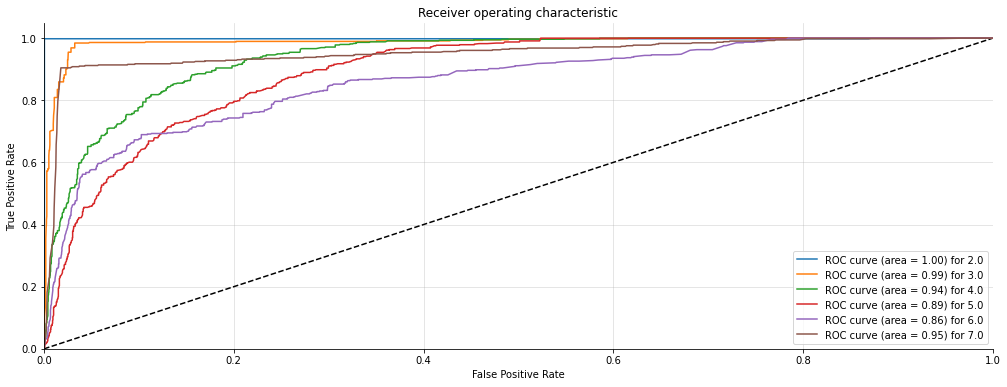

For column: easy
              precision    recall  f1-score   support

         2.0       0.99      1.00      1.00       544
         3.0       0.79      0.99      0.87       575
         4.0       0.70      0.62      0.66       589
         5.0       0.65      0.57      0.61       573
         6.0       0.73      0.69      0.71       541
         7.0       0.94      0.97      0.95       538

    accuracy                           0.80      3360
   macro avg       0.80      0.81      0.80      3360
weighted avg       0.80      0.80      0.80      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 567   6   2   0   0]
 [  3  77 365 111  27   6]
 [  0  47  77 328 110  11]
 [  0  27  70  55 373  16]
 [  1   3   3   7   4 520]]
Accuracy Score : 0.8023809523809524
Precision Score : 0.7965338961527718
Recall Score : 0.8023809523809524
F1 Score : 0.796529517166695


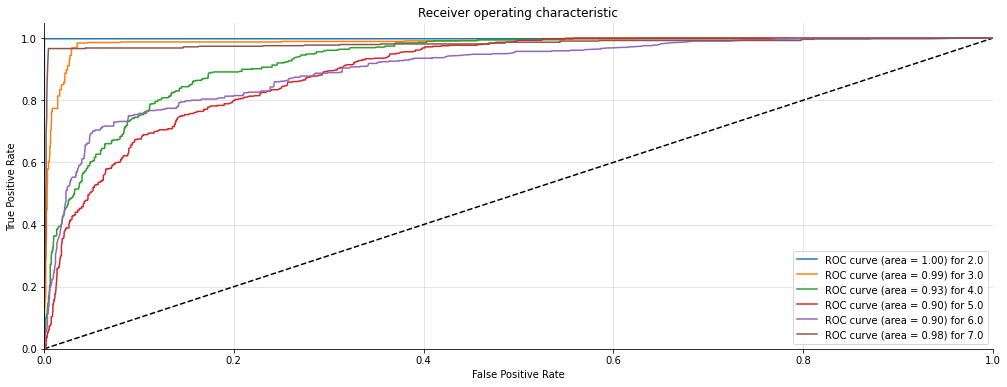

For column: efficient
              precision    recall  f1-score   support

         3.0       0.97      0.81      0.89       670
         4.0       0.63      0.76      0.69       681
         5.0       0.61      0.64      0.63       726
         6.0       0.66      0.68      0.67       639
         7.0       0.95      0.82      0.88       644

    accuracy                           0.74      3360
   macro avg       0.76      0.74      0.75      3360
weighted avg       0.76      0.74      0.75      3360

Confusion Matrix: 
 [[545 125   0   0   0]
 [ 10 520 123  25   3]
 [  4 112 464 131  15]
 [  1  51 145 433   9]
 [  1  20  23  69 531]]
Accuracy Score : 0.7419642857142857
Precision Score : 0.7613349936383595
Recall Score : 0.7419642857142857
F1 Score : 0.7479655591667455


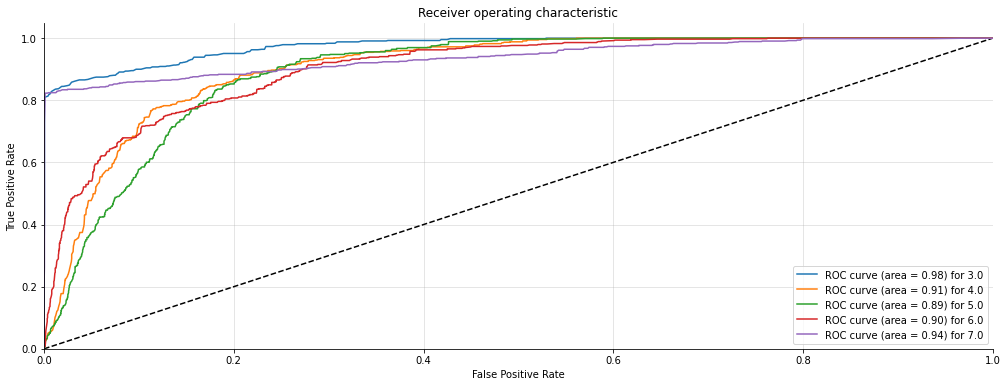

For column: clear
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.78      0.98      0.87       578
         4.0       0.70      0.63      0.66       595
         5.0       0.64      0.61      0.62       567
         6.0       0.71      0.59      0.64       540
         7.0       0.88      0.91      0.89       536

    accuracy                           0.79      3360
   macro avg       0.78      0.79      0.78      3360
weighted avg       0.78      0.79      0.78      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 568   8   1   1   0]
 [  0  80 377 107  25   6]
 [  0  41  70 347  98  11]
 [  1  25  73  72 319  50]
 [  0   9  13  19   7 488]]
Accuracy Score : 0.7863095238095238
Precision Score : 0.7814073587228159
Recall Score : 0.7863095238095238
F1 Score : 0.7807370651805632


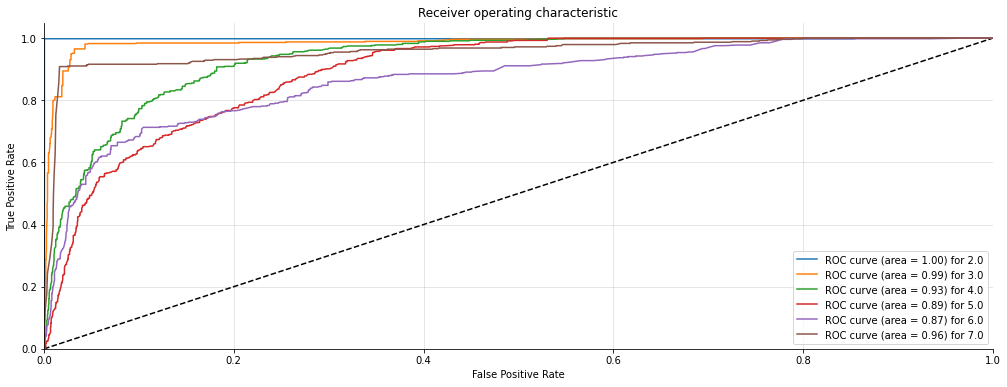

For column: exciting
              precision    recall  f1-score   support

         2.0       0.99      1.00      0.99       545
         3.0       0.79      0.97      0.87       574
         4.0       0.68      0.61      0.65       572
         5.0       0.70      0.59      0.64       602
         6.0       0.80      0.80      0.80       533
         7.0       0.96      0.99      0.97       534

    accuracy                           0.82      3360
   macro avg       0.82      0.83      0.82      3360
weighted avg       0.82      0.82      0.82      3360

Confusion Matrix: 
 [[543   1   1   0   0   0]
 [  1 559   5   7   2   0]
 [  0  82 351 105  31   3]
 [  4  52 107 356  69  14]
 [  0  11  49  41 425   7]
 [  0   0   1   0   4 529]]
Accuracy Score : 0.8223214285714285
Precision Score : 0.81673630572397
Recall Score : 0.8223214285714285
F1 Score : 0.8167717495152512


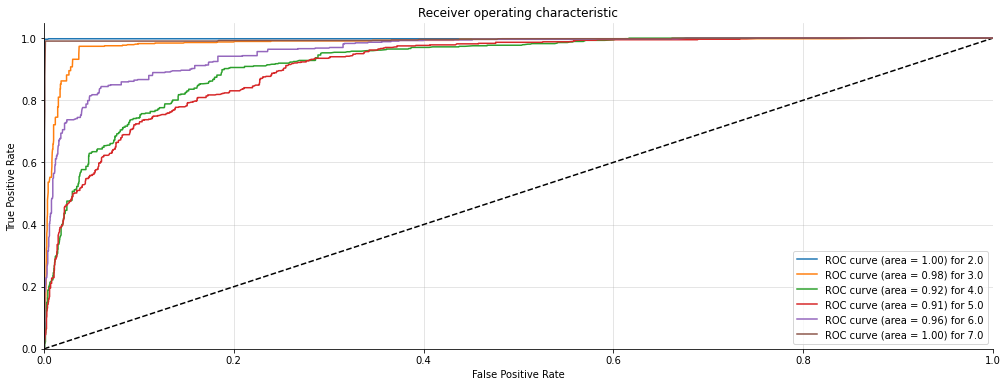

For column: interesting
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       545
         3.0       0.79      0.98      0.87       574
         4.0       0.71      0.63      0.67       578
         5.0       0.73      0.62      0.67       592
         6.0       0.81      0.81      0.81       537
         7.0       0.95      0.99      0.97       534

    accuracy                           0.83      3360
   macro avg       0.83      0.84      0.83      3360
weighted avg       0.83      0.83      0.83      3360

Confusion Matrix: 
 [[543   1   1   0   0   0]
 [  1 560   5   6   2   0]
 [  0  77 363  95  40   3]
 [  0  58  92 369  55  18]
 [  0  14  46  37 433   7]
 [  0   1   1   0   3 529]]
Accuracy Score : 0.8324404761904762
Precision Score : 0.8283878324184464
Recall Score : 0.8324404761904762
F1 Score : 0.8274399558120317


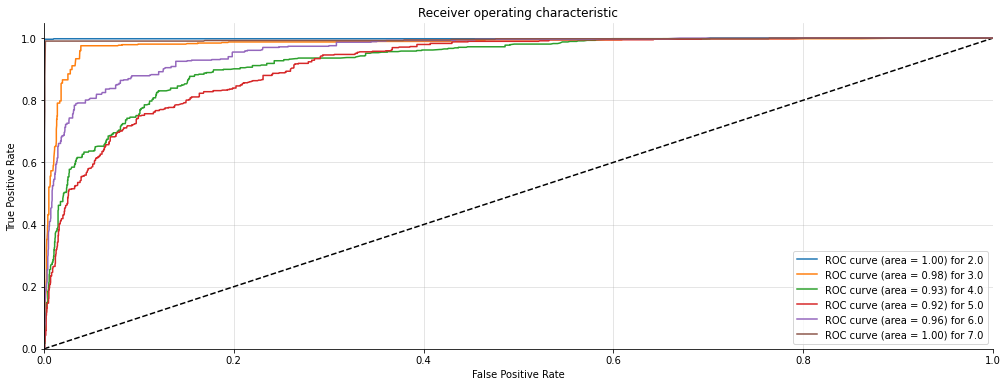

For column: inventive
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       545
         2.0       0.81      1.00      0.90       576
         3.0       0.78      0.66      0.71       589
         4.0       0.74      0.67      0.70       586
         5.0       0.83      0.82      0.83       533
         6.0       0.96      1.00      0.98       531

    accuracy                           0.85      3360
   macro avg       0.85      0.86      0.85      3360
weighted avg       0.85      0.85      0.85      3360

Confusion Matrix: 
 [[544   1   0   0   0   0]
 [  0 574   2   0   0   0]
 [  0  73 387  90  34   5]
 [  0  47  80 393  54  12]
 [  0  11  28  49 438   7]
 [  0   0   0   0   0 531]]
Accuracy Score : 0.8532738095238095
Precision Score : 0.8502087763661068
Recall Score : 0.8532738095238095
F1 Score : 0.8488751879259745


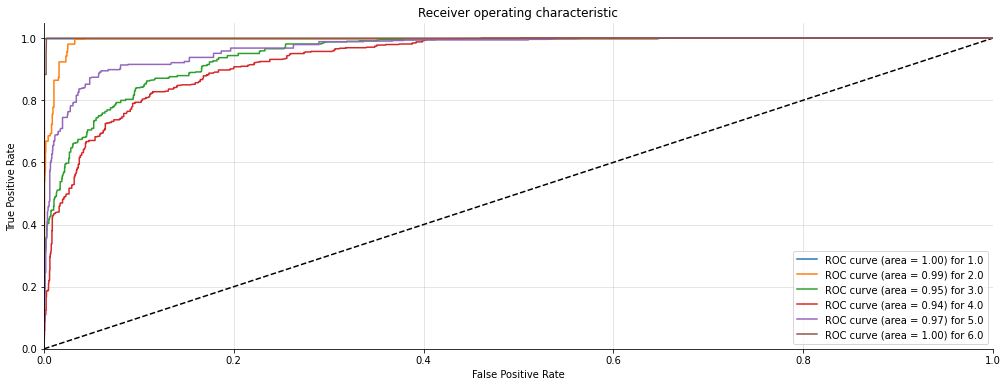

For column: leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       544
         2.0       0.83      1.00      0.91       576
         3.0       0.76      0.72      0.74       582
         4.0       0.78      0.66      0.71       589
         5.0       0.84      0.82      0.83       536
         6.0       0.96      1.00      0.98       533

    accuracy                           0.86      3360
   macro avg       0.86      0.87      0.86      3360
weighted avg       0.86      0.86      0.86      3360

Confusion Matrix: 
 [[544   0   0   0   0   0]
 [  0 576   0   0   0   0]
 [  0  55 420  72  30   5]
 [  0  49  90 387  52  11]
 [  0  11  40  40 440   5]
 [  0   0   0   0   0 533]]
Accuracy Score : 0.8630952380952381
Precision Score : 0.860110621156973
Recall Score : 0.8630952380952381
F1 Score : 0.8592648329169004


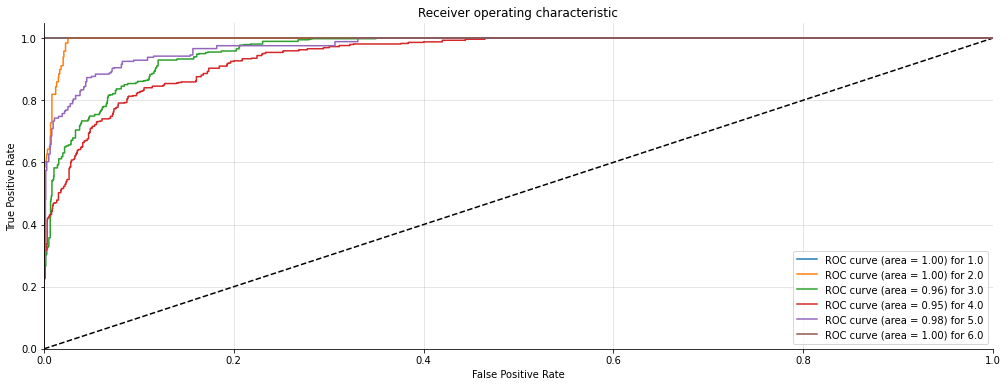

In [ ]:
# Again, initialize empty lists

acc = []
pre = []
recal = []
f1 = []
rms = []
aucscore = []
mae = []
fpo = dict()
tpo = dict()
ffpo = []
ttpo = []
    
clf = XGBClassifier(eval_metric='mlogloss')

plot_all_result_model(clf, X_test, y_train, y_test,
                      ffpo, ttpo)

### 3.5.2. Average XGBoost ROC

Here we plot the average ROC for each class, found with XGBoost.

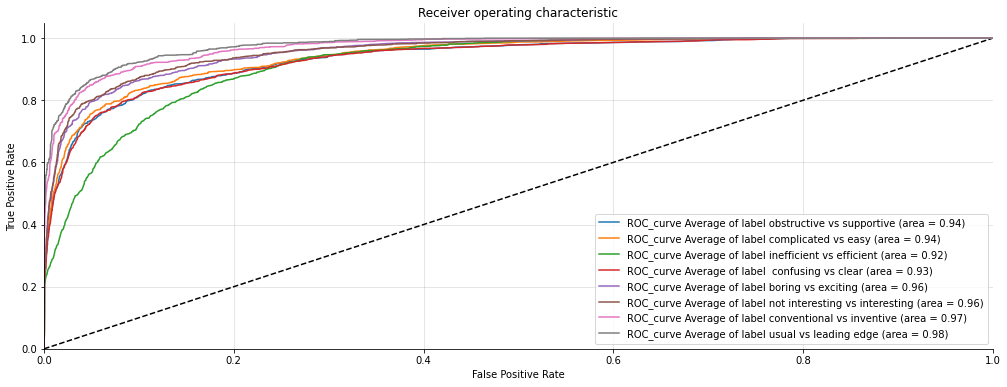

In [ ]:
xgb_classifier = XGBClassifier(eval_metric='mlogloss')
plot_multiclass_roc_optim(xgb_classifier,X_train, y_train, X_test, y_test) 

### 3.5.3. Average Classification Metrics

Here we display the average of each evaluation metric by calling `np.mean()` on each array -- remember, each array is comprised of multiple evaluation metrics; one for each column. 

In [ ]:
print("Average Accuracy : {}".format(np.mean(acc)))
print("Average Precision : {}".format(np.mean(pre)))
print("Average Recall : {}".format(np.mean(recal)))
print("Average F1-score : {}".format(np.mean(f1)))
print("Average RMSE-score : {}".format(np.mean(rms)))
print("Average AUC-score : {}".format(np.mean(aucscore)))
metric_df['XGB'] = [np.mean(acc), np.mean(pre), np.mean(recal),
                    np.mean(f1), np.mean(rms), np.mean(aucscore), np.mean(mae)]

Average Accuracy : 0.8111607142857142
Average Precision : 0.8096068533728245
Average Recall : 0.8111607142857142
Average F1-score : 0.8074591093874722
Average RMSE-score : 0.6290541897573358
Average AUC-score : 0.8854706028238077


## 3.6. SVM Method

Another comparison would be the SVM (Support Vector Machine) algorithm. We try and see whether this shallow learning algorithm can still predict correctly across all 8 classes compared to 2 previous implementations.

For column: supportive
              precision    recall  f1-score   support

         2.0       0.91      1.00      0.95       544
         3.0       0.69      0.92      0.79       576
         4.0       0.69      0.61      0.65       594
         5.0       0.66      0.54      0.60       571
         6.0       0.71      0.57      0.63       541
         7.0       0.85      0.90      0.87       534

    accuracy                           0.76      3360
   macro avg       0.75      0.76      0.75      3360
weighted avg       0.75      0.76      0.75      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [ 16 531   8   0   0  21]
 [ 19 115 363  71  18   8]
 [  3  76  86 310  89   7]
 [ 17  37  58  70 307  52]
 [  2   6   8  19  16 483]]
Accuracy Score : 0.7550595238095238
Precision Score : 0.7495408068826231
Recall Score : 0.7550595238095238
F1 Score : 0.7462240773730214


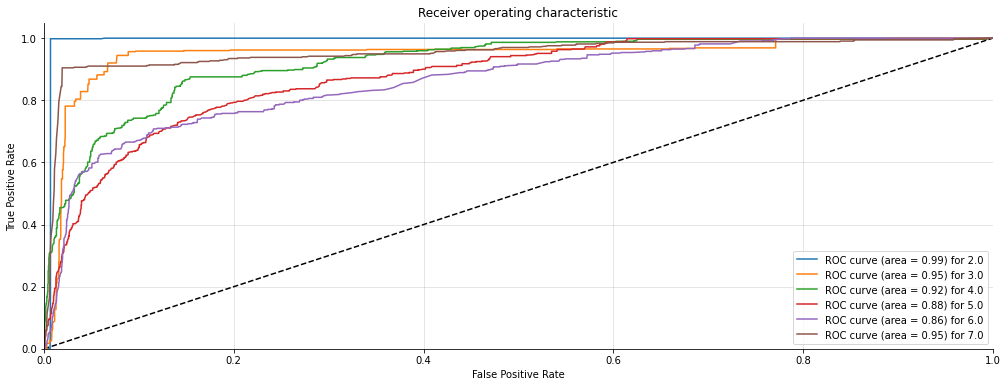

For column: easy
              precision    recall  f1-score   support

         2.0       0.90      1.00      0.95       544
         3.0       0.69      0.92      0.79       575
         4.0       0.70      0.59      0.64       589
         5.0       0.70      0.55      0.62       573
         6.0       0.77      0.67      0.72       541
         7.0       0.91      0.97      0.94       538

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.78      0.78      0.77      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [ 16 530   5   2   1  21]
 [ 21 116 350  78  18   6]
 [  4  75  87 315  85   7]
 [ 15  45  58  45 363  15]
 [  3   1   2   8   4 520]]
Accuracy Score : 0.7800595238095238
Precision Score : 0.7766847967563638
Recall Score : 0.7800595238095238
F1 Score : 0.7721354601545184


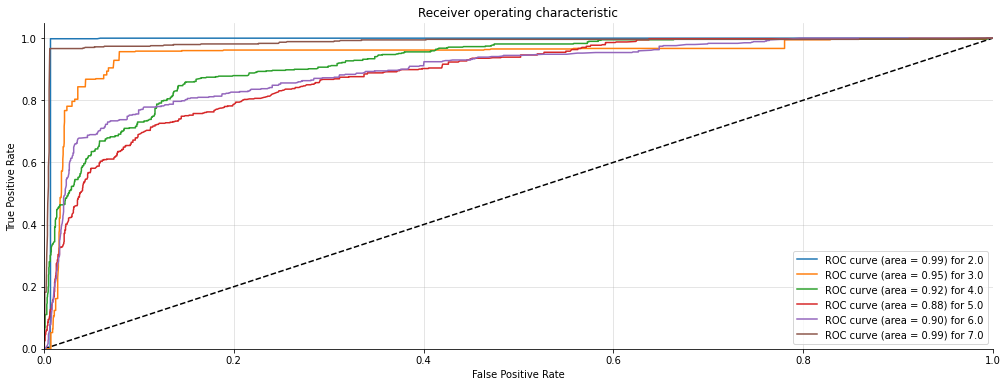

For column: efficient
              precision    recall  f1-score   support

         3.0       0.89      0.82      0.85       670
         4.0       0.56      0.76      0.64       681
         5.0       0.60      0.58      0.59       726
         6.0       0.72      0.62      0.66       639
         7.0       0.94      0.82      0.88       644

    accuracy                           0.72      3360
   macro avg       0.74      0.72      0.73      3360
weighted avg       0.74      0.72      0.72      3360

Confusion Matrix: 
 [[550 116   0   0   4]
 [ 34 515 113  12   7]
 [ 12 204 424  71  15]
 [ 17  71 152 393   6]
 [  8  19  16  70 531]]
Accuracy Score : 0.7181547619047619
Precision Score : 0.7370578979044515
Recall Score : 0.7181547619047619
F1 Score : 0.7227175884834174


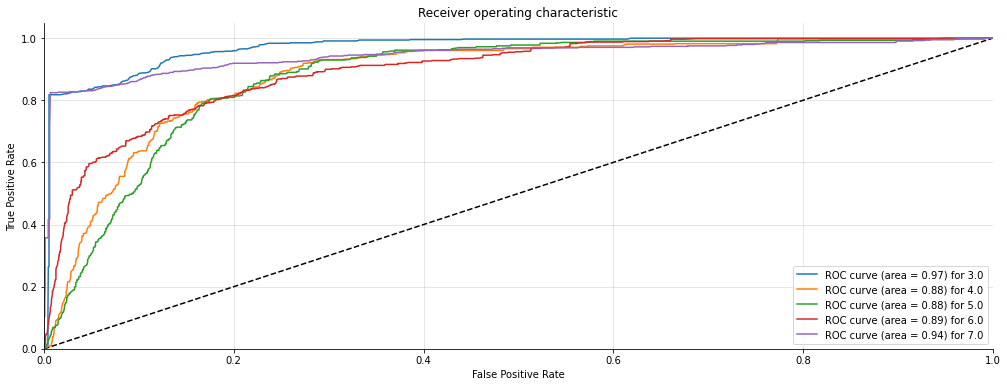

For column: clear
              precision    recall  f1-score   support

         2.0       0.90      1.00      0.95       544
         3.0       0.68      0.92      0.78       578
         4.0       0.72      0.61      0.66       595
         5.0       0.67      0.56      0.61       567
         6.0       0.72      0.59      0.65       540
         7.0       0.86      0.91      0.88       536

    accuracy                           0.76      3360
   macro avg       0.76      0.76      0.75      3360
weighted avg       0.76      0.76      0.75      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [ 16 531   7   2   1  21]
 [ 21 120 360  71  17   6]
 [  3  79  70 316  92   7]
 [ 17  37  51  70 317  48]
 [  2  11  10  15  11 487]]
Accuracy Score : 0.7601190476190476
Precision Score : 0.7566584009870992
Recall Score : 0.7601190476190476
F1 Score : 0.7519532504174382


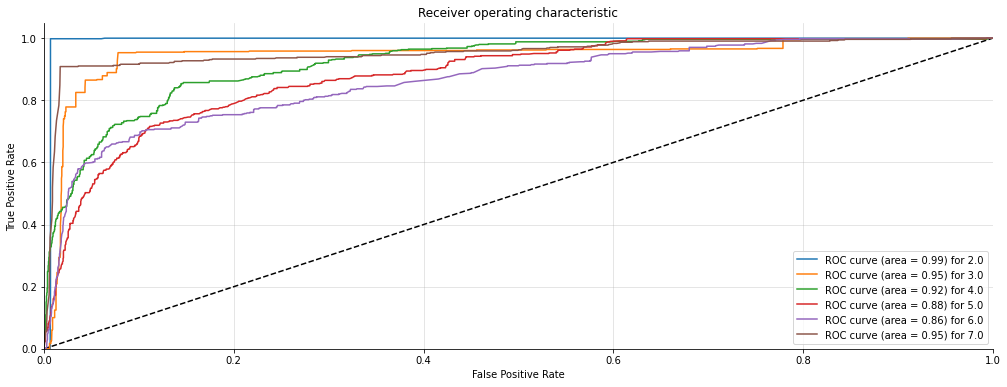

For column: exciting
              precision    recall  f1-score   support

         2.0       0.91      1.00      0.95       545
         3.0       0.69      0.93      0.79       574
         4.0       0.68      0.57      0.62       572
         5.0       0.78      0.59      0.67       602
         6.0       0.87      0.79      0.83       533
         7.0       0.94      0.99      0.97       534

    accuracy                           0.81      3360
   macro avg       0.81      0.81      0.80      3360
weighted avg       0.81      0.81      0.80      3360

Confusion Matrix: 
 [[543   2   0   0   0   0]
 [ 16 536   3   3   2  14]
 [ 23 129 327  69  20   4]
 [  2  87 112 356  37   8]
 [ 10  28  38  30 420   7]
 [  0   0   1   0   4 529]]
Accuracy Score : 0.8068452380952381
Precision Score : 0.8079037739951445
Recall Score : 0.8068452380952381
F1 Score : 0.8003565363814342


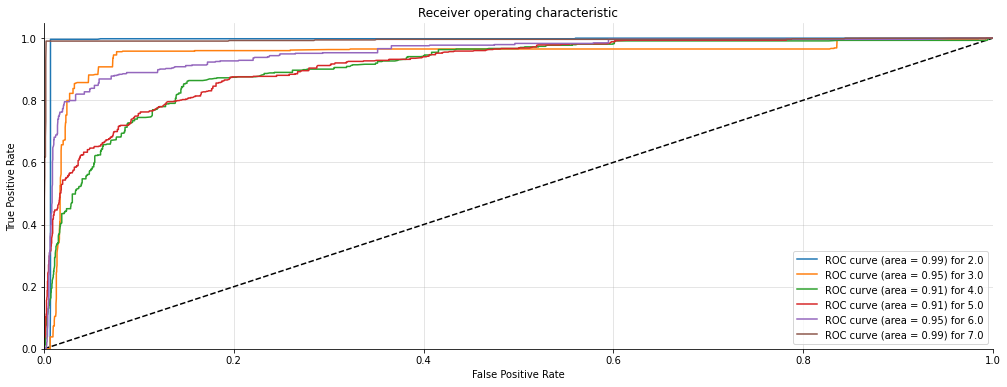

For column: interesting
              precision    recall  f1-score   support

         2.0       0.90      1.00      0.95       545
         3.0       0.69      0.93      0.79       574
         4.0       0.72      0.61      0.66       578
         5.0       0.80      0.61      0.69       592
         6.0       0.87      0.77      0.82       537
         7.0       0.94      0.99      0.97       534

    accuracy                           0.81      3360
   macro avg       0.82      0.82      0.81      3360
weighted avg       0.82      0.81      0.81      3360

Confusion Matrix: 
 [[543   2   0   0   0   0]
 [ 17 533   6   3   1  14]
 [ 21 123 353  55  21   5]
 [  3  91  94 364  33   7]
 [ 17  27  39  35 412   7]
 [  0   0   1   0   4 529]]
Accuracy Score : 0.8136904761904762
Precision Score : 0.8167933078022993
Recall Score : 0.8136904761904762
F1 Score : 0.80834388537611


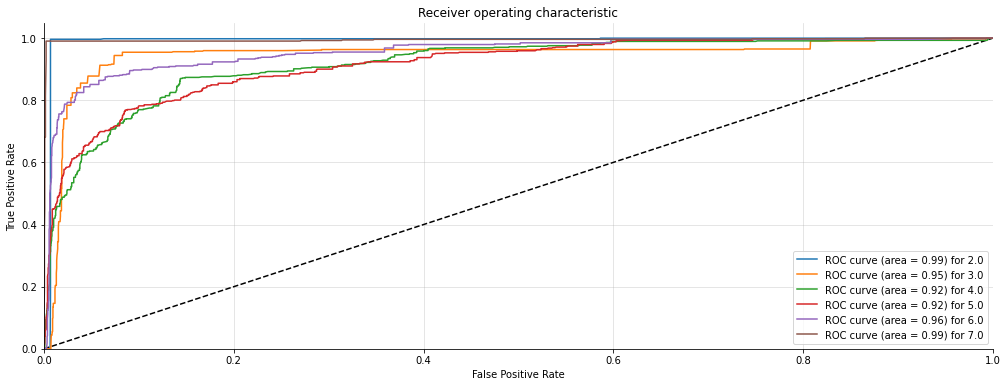

For column: inventive
              precision    recall  f1-score   support

         1.0       0.91      1.00      0.95       545
         2.0       0.71      0.94      0.80       576
         3.0       0.75      0.63      0.68       589
         4.0       0.83      0.66      0.73       586
         5.0       0.89      0.80      0.85       533
         6.0       0.94      1.00      0.97       531

    accuracy                           0.83      3360
   macro avg       0.84      0.84      0.83      3360
weighted avg       0.84      0.83      0.83      3360

Confusion Matrix: 
 [[544   1   0   0   0   0]
 [ 16 539   7   0   0  14]
 [ 22 120 369  58  16   4]
 [  2  78  80 385  35   6]
 [ 17  26  36  19 428   7]
 [  0   0   0   0   0 531]]
Accuracy Score : 0.8321428571428572
Precision Score : 0.83563138687498
Recall Score : 0.8321428571428572
F1 Score : 0.8274518485967612


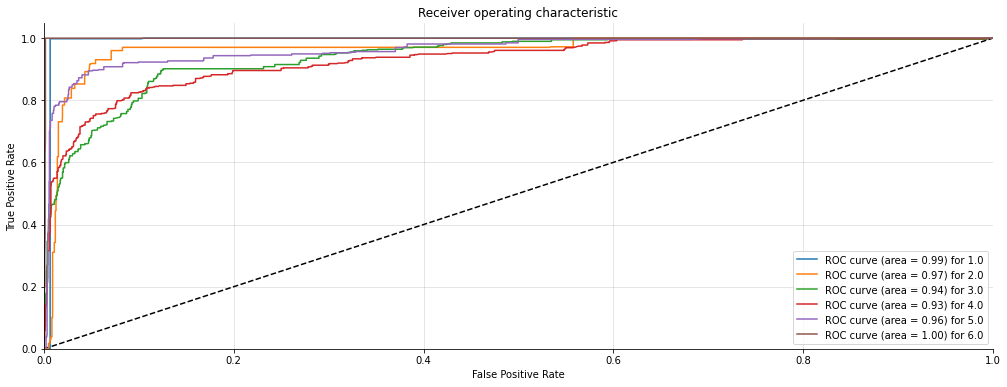

For column: leading edge
              precision    recall  f1-score   support

         1.0       0.92      1.00      0.96       544
         2.0       0.70      0.94      0.80       576
         3.0       0.77      0.64      0.70       582
         4.0       0.85      0.69      0.76       589
         5.0       0.92      0.81      0.86       536
         6.0       0.95      1.00      0.97       533

    accuracy                           0.84      3360
   macro avg       0.85      0.85      0.84      3360
weighted avg       0.85      0.84      0.84      3360

Confusion Matrix: 
 [[544   0   0   0   0   0]
 [ 16 540   6   0   0  14]
 [ 22 116 372  55  13   4]
 [  2  81  68 408  24   6]
 [ 10  32  37  16 436   5]
 [  0   0   0   0   0 533]]
Accuracy Score : 0.8431547619047619
Precision Score : 0.8488672811410958
Recall Score : 0.8431547619047619
F1 Score : 0.8396789268921511


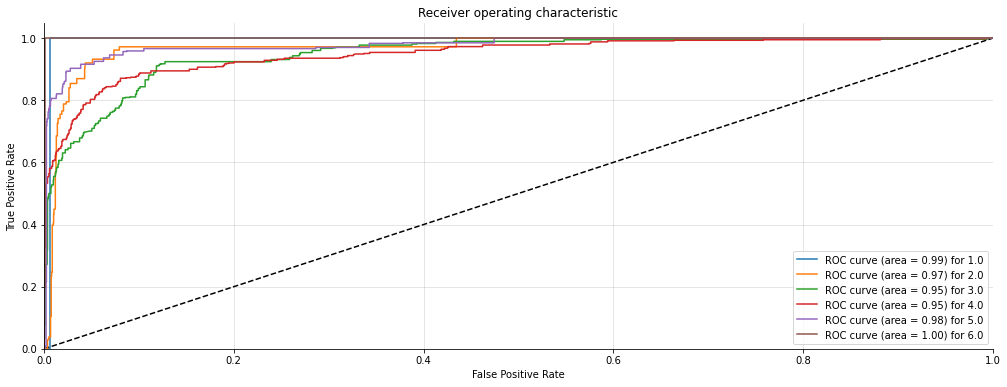

In [ ]:
acc = []
pre = []
recal = []
mae = []
f1 = []
rms = []
aucscore = []
fpo = dict()
tpo = dict()
ffpo = []
ttpo = []

clf = SVC(probability=True) # Make SVC classifier
plot_all_result_model(clf, X_test, y_train, y_test,
                      ffpo, ttpo) # Invoke function

### 3.6.1. Average SVM ROC

Here we plot the average ROC for each class, found with SVM.

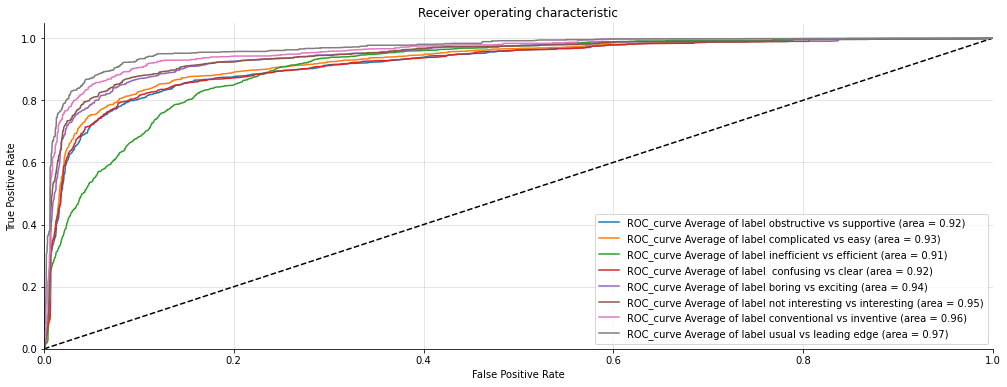

In [ ]:
clf = SVC(probability=True)
plot_multiclass_roc_optim(clf, X_train, y_train, X_test, y_test)

### 3.6.2. Average Classification Metrics

Here we display the average of each evaluation metric by calling `np.mean()` on each array -- remember, each array is comprised of multiple evaluation metrics; one for each column. 

In [ ]:
print("Average Accuracy : {}".format(np.mean(acc)))
print("Average Precision : {}".format(np.mean(pre)))
print("Average Recall : {}".format(np.mean(recal)))
print("Average F1-score : {}".format(np.mean(f1)))
print("Average RMSE score : {}".format(np.mean(rms)))
print("Average AUC score : {}".format(np.mean(aucscore)))
metric_df['SVM'] = [np.mean(acc), np.mean(pre), np.mean(recal),
                    np.mean(f1), np.mean(rms), np.mean(aucscore), np.mean(mae)]

Average Accuracy : 0.7886532738095238
Average Precision : 0.7911422065430072
Average Recall : 0.7886532738095238
Average F1-score : 0.7836076967093565
Average RMSE score : 0.7839059574870244
Average AUC score : 0.8718729141730868


## 3.7. Custom-Built Ordinal Classifier

Credit: [Muhammad for Towards Data Science](https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c)

Ordinal classifier basically does a similar thing to one-hot encoding -- but despite having one value each column, ordinal encoding maps unique binary values for each of our unique classes.

We implement a custom object called `OrdinalClassifier` built on top of any `sklearn` model that supports the `predict_proba()` function; ranging from Naive Bayes to decision trees.

Last implementation, we deduced the labels by one, from `[1,2,3,4,5,6,7]` to `[0,1,2,3,4,5,6]` due to the nature of zero-indexing of standard sklearn library. But this doesn't work if the labels aren't ranging fully from 1 to 7 -- could be 2 to 6 or 2 to 7 instead.

So the solution is to change the overall behavior of the `OrdinalClassifier` object to take maximum class (e.g. 7) and minimum class (e.g. 2 or 3) into consideration. From there, we simulate the `np.argmax()` function to be added the minimum class before being returned. We also add the minimum class as an index towards `self.clfs` dictionary when adding new value, so we don't need to deduce the labels by hand. In other words, labels stay as-is instead of being deduced by 1 :)

This also changes how the approach for ordinal encoding works -- instead of `k - 1` like the author's original implementation, we feed `k` numbers of encoding because our labels are already one-indexed.

Keep in mind that the `predict_proba()` function does not yet implement this change, because it's only a wrapper function before eventually calling `predict()` in which we care the most about the result. 

In [ ]:
class OrdinalClassifier():

    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}

    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        self.max_class = max(self.unique_class)
        self.min_class = min(self.unique_class)
        if self.unique_class.shape[0] > 2:
            # print(self.unique_class.shape[0]) # Uncomment to debug
            for i in range(self.unique_class.shape[0]):
                # for each k ordinal value
                # we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i+self.min_class] = clf

    def predict_proba(self, X):
        clfs_predict = {
            k:self.clfs[k].predict_proba(X) for k in self.clfs
        }
        # print(self.clfs) # Uncomment to debug
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1-clfs_predict[y][:, 1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(
                     clfs_predict[y-1][:, 1] - clfs_predict[y][:, 1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:, 1])
        return np.vstack(predicted).T

    def predict(self, X):
        return np.argmax(
            self.predict_proba(X), axis=1) + self.min_class

For column: supportive
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.84      0.98      0.90       576
         4.0       0.63      0.61      0.62       594
         5.0       0.54      0.49      0.51       571
         6.0       0.65      0.61      0.63       541
         7.0       0.89      0.90      0.90       534

    accuracy                           0.76      3360
   macro avg       0.76      0.77      0.76      3360
weighted avg       0.75      0.76      0.76      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 567   6   2   1   0]
 [  0  51 362 147  31   3]
 [  0  31 123 278 134   5]
 [  0  23  75  63 331  49]
 [  1   6   8  23  13 483]]
Accuracy Score : 0.763095238095238
Precision Score : 0.7549960331953902
Recall Score : 0.763095238095238
F1 Score : 0.7576200197273073


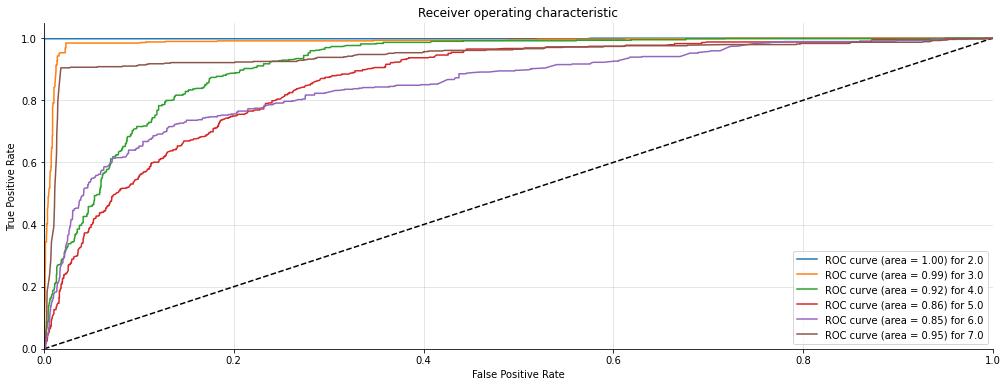

For column: easy
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.82      0.98      0.89       575
         4.0       0.64      0.60      0.62       589
         5.0       0.59      0.49      0.54       573
         6.0       0.65      0.66      0.65       541
         7.0       0.96      0.97      0.96       538

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.77      0.78      0.77      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 566   5   2   2   0]
 [  0  58 355 121  54   1]
 [  0  30 122 281 134   6]
 [  0  33  69  67 357  15]
 [  1   3   2   6   6 520]]
Accuracy Score : 0.7803571428571429
Precision Score : 0.7723402898083773
Recall Score : 0.7803571428571429
F1 Score : 0.7741605688739556


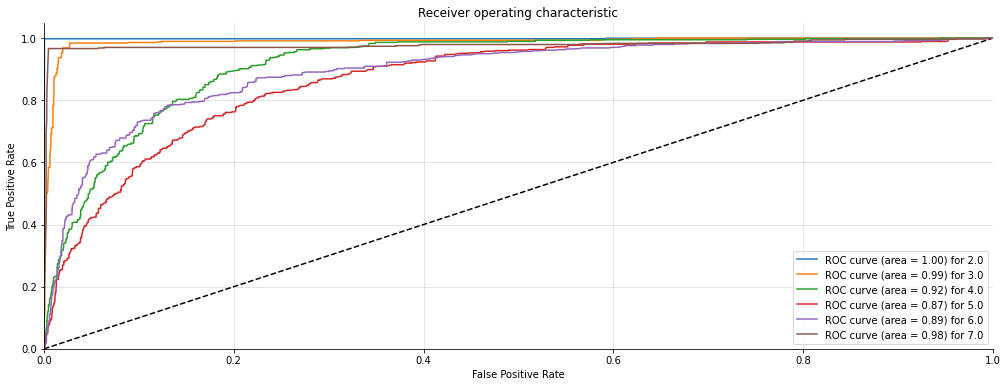

For column: efficient
              precision    recall  f1-score   support

         3.0       0.97      0.82      0.89       670
         4.0       0.62      0.75      0.68       681
         5.0       0.57      0.57      0.57       726
         6.0       0.61      0.67      0.64       639
         7.0       0.96      0.82      0.89       644

    accuracy                           0.72      3360
   macro avg       0.75      0.73      0.73      3360
weighted avg       0.74      0.72      0.73      3360

Confusion Matrix: 
 [[548 122   0   0   0]
 [ 12 508 129  30   2]
 [  2 126 415 173  10]
 [  0  49 152 430   8]
 [  1  17  27  68 531]]
Accuracy Score : 0.7238095238095238
Precision Score : 0.7447397148696598
Recall Score : 0.7238095238095238
F1 Score : 0.7304128708284927


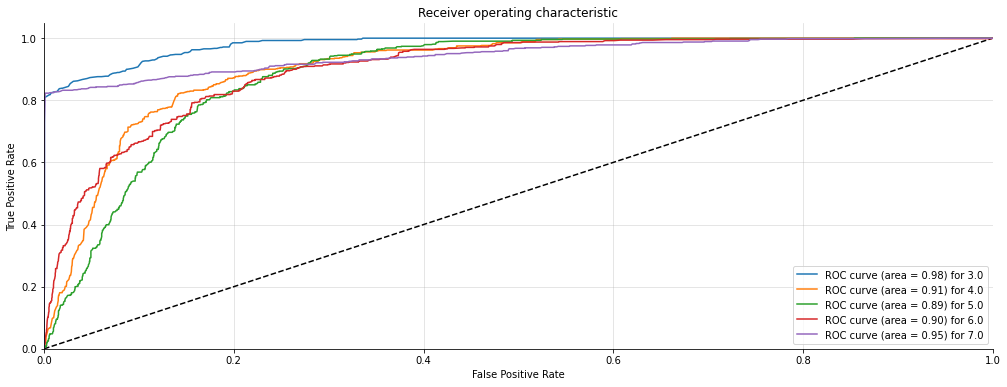

For column: clear
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.83      0.98      0.90       578
         4.0       0.65      0.62      0.64       595
         5.0       0.55      0.52      0.54       567
         6.0       0.62      0.58      0.60       540
         7.0       0.90      0.91      0.90       536

    accuracy                           0.77      3360
   macro avg       0.76      0.77      0.76      3360
weighted avg       0.76      0.77      0.76      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 567   8   1   2   0]
 [  0  47 369 133  45   1]
 [  0  29 112 294 126   6]
 [  1  28  64  88 311  48]
 [  0   8  11  16  14 487]]
Accuracy Score : 0.7651785714285714
Precision Score : 0.7578606523535675
Recall Score : 0.7651785714285714
F1 Score : 0.7601586427123241


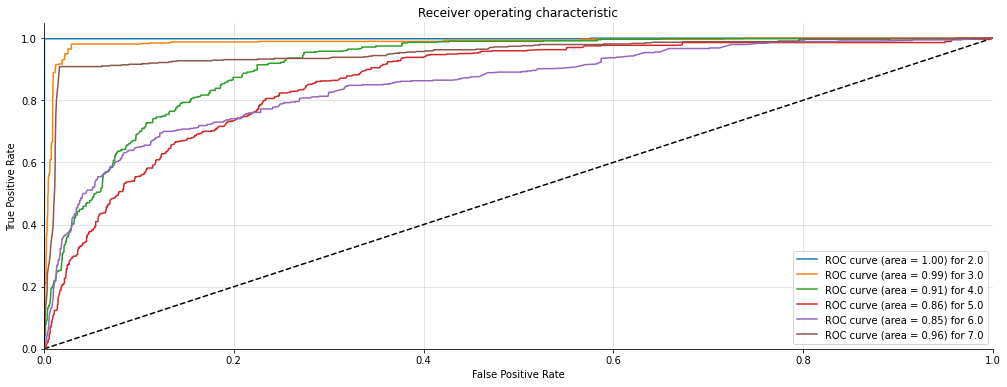

For column: exciting
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       545
         3.0       0.81      0.97      0.88       574
         4.0       0.64      0.51      0.57       572
         5.0       0.62      0.57      0.60       602
         6.0       0.70      0.77      0.73       533
         7.0       0.98      0.99      0.98       534

    accuracy                           0.79      3360
   macro avg       0.79      0.80      0.79      3360
weighted avg       0.79      0.79      0.79      3360

Confusion Matrix: 
 [[543   2   0   0   0   0]
 [  1 559   8   4   2   0]
 [  0  73 289 146  63   1]
 [  0  37 110 343 107   5]
 [  0  21  41  56 408   7]
 [  0   0   1   0   4 529]]
Accuracy Score : 0.7949404761904761
Precision Score : 0.7873575282996464
Recall Score : 0.7949404761904761
F1 Score : 0.7879298634645988


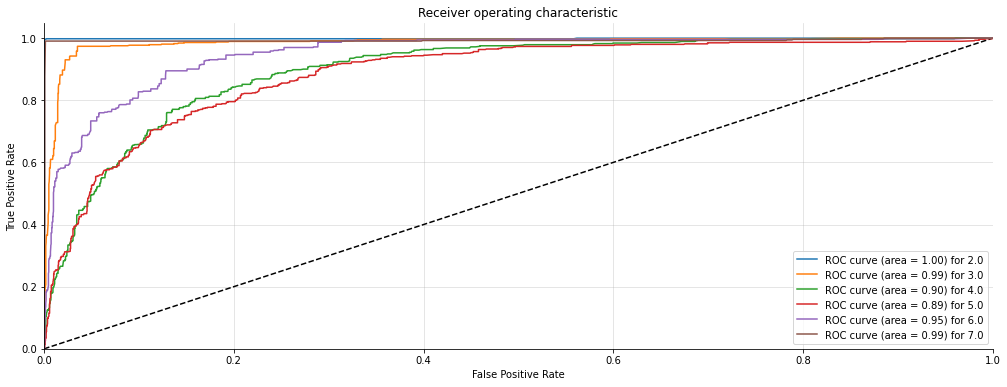

For column: interesting
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       545
         3.0       0.82      0.98      0.89       574
         4.0       0.65      0.53      0.59       578
         5.0       0.64      0.58      0.61       592
         6.0       0.73      0.80      0.76       537
         7.0       0.99      0.99      0.99       534

    accuracy                           0.81      3360
   macro avg       0.80      0.81      0.81      3360
weighted avg       0.80      0.81      0.80      3360

Confusion Matrix: 
 [[543   2   0   0   0   0]
 [  1 560   6   4   3   0]
 [  0  69 306 146  56   1]
 [  0  31 115 342  99   5]
 [  0  21  40  42 432   2]
 [  0   0   1   0   4 529]]
Accuracy Score : 0.8071428571428572
Precision Score : 0.8000854252348313
Recall Score : 0.8071428571428572
F1 Score : 0.8007383798462784


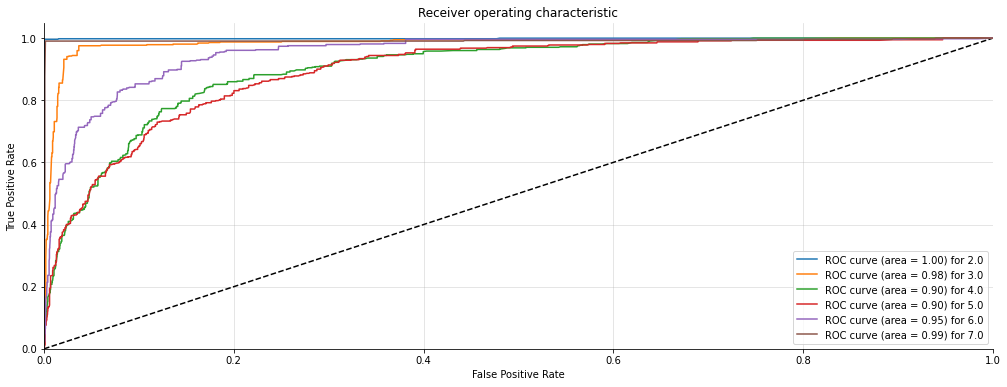

For column: inventive
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       545
         2.0       0.84      1.00      0.91       576
         3.0       0.74      0.65      0.69       589
         4.0       0.66      0.56      0.61       586
         5.0       0.73      0.80      0.76       533
         6.0       0.98      1.00      0.99       531

    accuracy                           0.83      3360
   macro avg       0.83      0.83      0.83      3360
weighted avg       0.82      0.83      0.82      3360

Confusion Matrix: 
 [[544   1   0   0   0   0]
 [  0 575   0   0   1   0]
 [  0  54 382 110  43   0]
 [  0  31 110 330 111   4]
 [  0  21  21  58 426   7]
 [  0   0   0   0   0 531]]
Accuracy Score : 0.8297619047619048
Precision Score : 0.8239777080702692
Recall Score : 0.8297619047619048
F1 Score : 0.8242217333465715


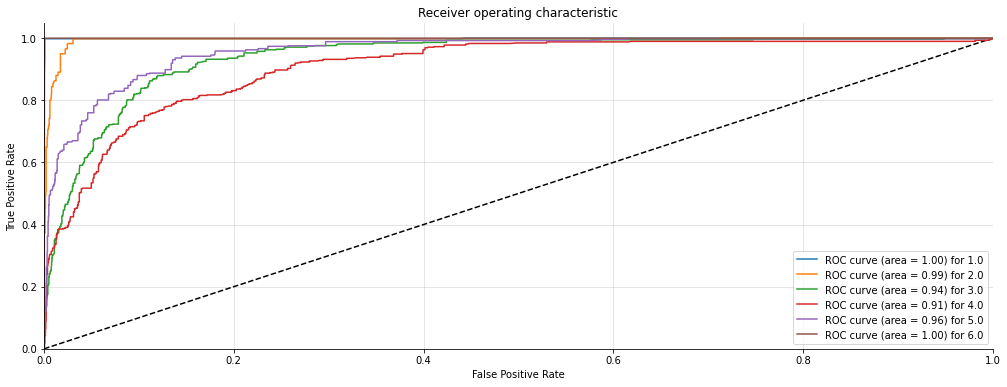

For column: leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       544
         2.0       0.85      1.00      0.92       576
         3.0       0.76      0.63      0.69       582
         4.0       0.69      0.63      0.66       589
         5.0       0.75      0.80      0.77       536
         6.0       0.98      1.00      0.99       533

    accuracy                           0.84      3360
   macro avg       0.84      0.84      0.84      3360
weighted avg       0.84      0.84      0.84      3360

Confusion Matrix: 
 [[544   0   0   0   0   0]
 [  0 576   0   0   0   0]
 [  0  49 367 113  53   0]
 [  0  32  86 374  93   4]
 [  0  21  27  55 428   5]
 [  0   0   0   0   0 533]]
Accuracy Score : 0.8398809523809524
Precision Score : 0.8358867020183487
Recall Score : 0.8398809523809524
F1 Score : 0.8353643849188925


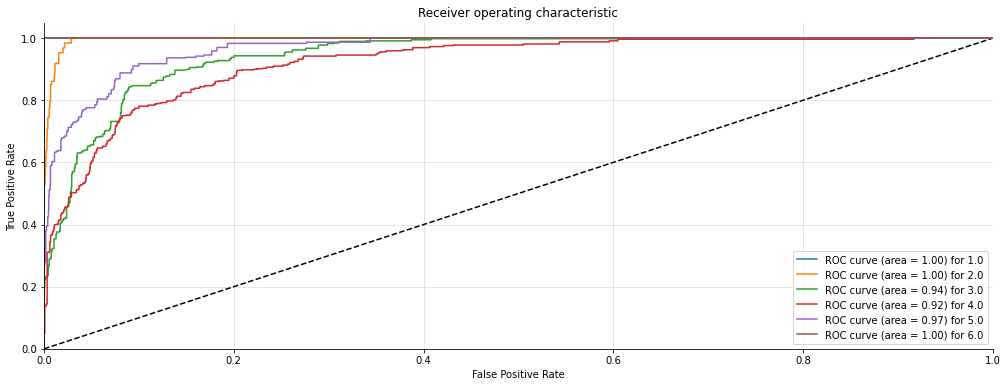

In [ ]:
from sklearn.base import clone

acc = []
pre = []
recal = []
f1 = []
mae = []
rms = []
aucscore = []
fpo = dict()
tpo = dict()
ffpo = []
ttpo = []


clf = OrdinalClassifier(XGBClassifier(eval_metric='mlogloss')) # Make a classifier
plot_all_result_model(clf, X_test, y_train, y_test, # Invoke the function from before
                      ffpo, ttpo)   

### 3.7.1. Average Ordinal Classifier ROC

Here we plot the average ROC for each class, found with the custom-built Ordinal Classifier we made earlier.

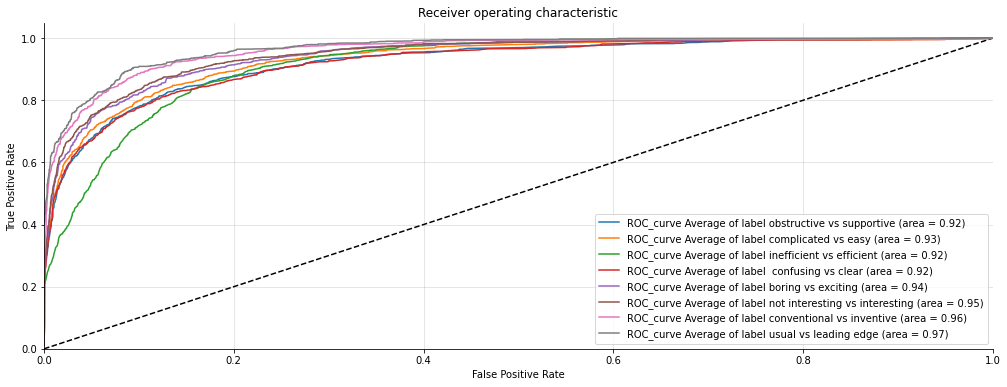

In [ ]:
plot_multiclass_roc_optim(clf,X_train, y_train, X_test, y_test)

In [ ]:
print("Average Accuracy : {}".format(np.mean(acc)))
print("Average Precision : {}".format(np.mean(pre)))
print("Average Recall : {}".format(np.mean(recal)))
print("Average F1 -score : {}".format(np.mean(f1)))
print("Average RMSE score : {}".format(np.mean(rms)))
print("Average AUC score: {}".format(np.mean(aucscore)))
metric_df['OrdinalModel'] = [np.mean(acc), np.mean(pre),
                             np.mean(recal), np.mean(f1), np.mean(rms),
                             np.mean(aucscore), np.mean(mae)]

Average Accuracy : 0.7880208333333334
Average Precision : 0.7846555067312613
Average Recall : 0.7880208333333334
Average F1 -score : 0.7838258079648026
Average RMSE score : 0.6426740709953511
Average AUC score: 0.8715101293824516


# 4. Other Learning Algorithm(s)

Some of the learning algorithms we try and implement other than SVM, XGB, and fully-connected neural networks are as follows:
1. Bidirectional LSTM
2. Radial Basis Function Network (RBFN)
3. Multiclass Logistic Regression
4. LSTM
5. Ensemble: Random Forest
6. Ensemble: Extra Trees
7. Ensemble: Adaboost
8. Ensemble: Bagging Classifiers

## 4.1. Bidirectional LSTM

Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems. In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence.

Bidirectional LSTMs basically **look both ways** when training on sequence-based data.

In [ ]:
# Callbacks
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_checkpoints", monitor="val_loss",
    verbose=1, save_best_only=True, mode="min")

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function
    # since they are very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu',
                          # Prevent overfitting
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01),
                          # Ensuring consistent outputs and not run
                          # into potential local optima
                          # Avoid initializing standard normal
                          # (mean = 0, std = 1)
                          # to reach faster convergence and less initial loss.
                          kernel_initializer=tf.keras.initializers.RandomNormal(
                              seed=42)), tf.keras.layers.Dropout(0.3),
                              tf.keras.layers.Dense(8, activation='linear')])
LSTM_model.summary()

LSTM_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=opt, metrics=['mae'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          128000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                 520       
                                                                 
Total params: 202,824
Trainable params: 202,824
Non-trainable params: 0
__________________________________________________

In [ ]:
history = LSTM_model.fit(X_train, y_train,
                         epochs=100, batch_size=512,
                         validation_split=0.2,
                         callbacks=[es],
                         verbose=1)

Epoch 1/100
21/21 [==============================] - 10s 169ms/step - loss: 18.7021 - mae: 3.8773 - val_loss: 7.0319 - val_mae: 2.1649
Epoch 2/100
21/21 [==============================] - 1s 26ms/step - loss: 5.4854 - mae: 1.8790 - val_loss: 3.1925 - val_mae: 1.4935
Epoch 3/100
21/21 [==============================] - 2s 121ms/step - loss: 4.2390 - mae: 1.6828 - val_loss: 2.8309 - val_mae: 1.4317
Epoch 4/100
21/21 [==============================] - 2s 96ms/step - loss: 3.8136 - mae: 1.6013 - val_loss: 2.5529 - val_mae: 1.3635
Epoch 5/100
21/21 [==============================] - 0s 24ms/step - loss: 3.3333 - mae: 1.4979 - val_loss: 2.0124 - val_mae: 1.2116
Epoch 6/100
21/21 [==============================] - 2s 96ms/step - loss: 2.5625 - mae: 1.2693 - val_loss: 1.3518 - val_mae: 0.9313
Epoch 7/100
21/21 [==============================] - 4s 190ms/step - loss: 1.8875 - mae: 1.0432 - val_loss: 0.8278 - val_mae: 0.6781
Epoch 8/100
21/21 [==============================] - 1s 26ms/step - los

### 4.1.1. Interpretation

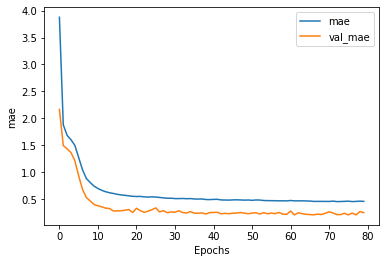

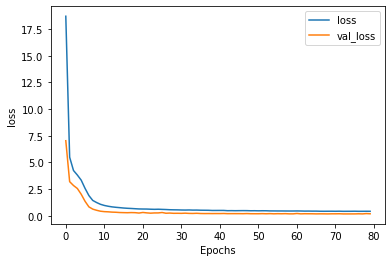

In [ ]:
plot_graphs(history, "mae")
plot_graphs(history, "loss")

In [ ]:
scores = LSTM_model.evaluate(
    X_test, y_test, batch_size=1,
    verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4,
    use_multiprocessing=False,
    return_dict=False)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 21s 6ms/step - loss: 0.1745 - mae: 0.2403
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 17.45%
mae: 24.03%


### 4.1.2. List Initialization
Like before, we can initialize some empty list to keep track of the evaluation metrics we're going to use.

In [ ]:
acc = []
pre = []
recal = []
mae = []
f1 = []
rms = []
aucscore = []

In [ ]:
y_pred = LSTM_model.predict(X_test)
for i in range(8):
    print("Column", df.columns[1:][i]) # Print which column we're analyzing

    # Rounding the predictions because we're approaching a problem as a regression task
    # despite we have 7 output nodes. This way, regression outputs, which would be continuous,
    # are seen as classes instead.
    estimates = [round(float(x)) for x in y_pred[:, i]]
    estimates = transform_results(estimates)

    # print(np.unique(estimates)) # Uncomment to see the unique classes in that column
    # Append all the scores to our previously initialized list
    acc.append(accuracy_score(y_test[:, i], estimates))
    pre.append(precision_score(y_test[:, i], estimates, average='weighted'))
    recal.append(recall_score(y_test[:, i], estimates, average='weighted'))
    f1.append(f1_score(y_test[:, i], estimates, average='weighted'))
    rms.append(np.sqrt(mean_squared_error(y_test[:, i], estimates)))
    mae.append(mean_absolute_error(y_test[:, i], estimates))
    aucscore.append(score_auc(y_test[:, i], estimates))

Column supportive
Column easy
Column efficient
Column clear
Column exciting
Column interesting
Column inventive
Column leading edge


In [ ]:
print("Average Accuracy : {}".format(np.mean(acc)))
print("Average Precision : {}".format(np.mean(pre)))
print("Average Recall : {}".format(np.mean(recal)))
print("Average F1 score : {}".format(np.mean(f1)))
print("Average RMSE score : {}".format(np.mean(rms)))
print("Average AUC score : {}".format(np.mean(aucscore)))
metric_df['Bidirectional LSTM'] = [np.mean(acc),
                                   np.mean(pre), np.mean(recal),
                                   np.mean(f1),
                                   np.mean(rms), np.mean(aucscore),
                                   np.mean(mae)]

Average Accuracy : 0.9014136904761905
Average Precision : 0.905716502084486
Average Recall : 0.9014136904761905
Average F1 score : 0.902197069922839
Average RMSE score : 0.36563939608155144
Average AUC score : 0.9398928353924897


In [ ]:
LSTM_y_pred = LSTM_model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened] # Again, rounding the outputs.

print("First ten examples of the test set:")
print("Truth labels:", y_test_flattened[:10])
print("Predicted labels:", LSTM_y_classified[:10])
print("Overall performance on all columns:\n",
      classification_report(y_test_flattened, LSTM_y_classified))

First ten examples of the test set:
Truth labels: [3. 2. 3. 2. 5. 4. 4. 4. 4. 7.]
Predicted labels: [3, 2, 3, 2, 5, 4, 4, 4, 4, 2]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1089
         2.0       1.00      1.00      1.00      3874
         3.0       0.97      0.95      0.96      4718
         4.0       0.85      0.87      0.86      4784
         5.0       0.77      0.85      0.81      4700
         6.0       0.88      0.82      0.85      4395
         7.0       0.96      0.93      0.94      3320

    accuracy                           0.90     26880
   macro avg       0.92      0.91      0.92     26880
weighted avg       0.90      0.90      0.90     26880



## 4.2 RBFN
In the field of mathematical modeling, a radial basis function network (abbreviated RBFN) is an artificial neural network that uses radial basis functions as activation functions. The output of the network is a linear combination of radial basis functions of the inputs and neuron parameters.

Here, we try to construct a custom RBF class which can then be called like so:
```python
model = Sequential()
model.add(RBFLayer(10,
   initializer=InitCentersRandom(X),
   betas=1.0,
   input_shape=(1,)))
model.add(Dense(1))
```

In [ ]:
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.initializers import RandomUniform, Initializer, Constant
from sklearn.cluster import KMeans


class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        print("done")
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

After defining our RBF class, we can start to build our model based on the `RBFLayer` class.

In [ ]:
from tensorflow.keras.layers import Dense, Activation
model = Sequential()
rbflayer = RBFLayer(100,
                    initializer=InitCentersKMeans(X_train),
                    betas=3.0,
                    input_shape=(X_train.shape[1],)) # Here is our previously initialize RBF class
model.add(rbflayer)
model.add(Dense(8))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error',
              optimizer='adam', metrics=['accuracy'])
model.build(X_train.shape)
print(model.summary())
history1 = model.fit(X_train, y_train, epochs=100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer (RBFLayer)        (None, 100)               2100      
                                                                 
 dense_10 (Dense)            (None, 8)                 808       
                                                                 
 activation (Activation)     (None, 8)                 0         
                                                                 
Total params: 2,908
Trainable params: 2,908
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
420/420 [==============================] - 2s 3ms/step - loss: 19.9404 - accuracy: 0.4516
Epoch 2/100
420/420 [==============================] - 1s 3ms/step - loss: 16.7170 - accuracy: 0.4763
Epoch 3/100
420/420 [==============================] - 1s 3ms/step - loss: 13.9596 - accuracy: 0.4764
Epoch

In [ ]:
scores = model.evaluate(
    X_test, y_test, batch_size=1,
    verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10,
    workers=4, use_multiprocessing=False,
    return_dict=False)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 9s 3ms/step - loss: 2.5107 - accuracy: 0.4818
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 251.07%
accuracy: 48.18%


### 4.2.1. List Initialization
Like before, we can initialize some empty list to keep track of the evaluation metrics we're going to use.

In [ ]:
acc = []
pre = []
recal = []
mae = []
f1 = []
rms = []
aucscore = []

In [ ]:
y_pred = model.predict(X_test)
for i in range(8): # Loop over columns
    print("Column", df.columns[1:][i]) # Print which column we're analyzing

    # Rounding the predictions because we're approaching a problem as a regression task
    # despite we have 7 output nodes. This way, regression outputs, which would be continuous,
    # are seen as classes instead.
    estimates = [round(float(x)) for x in y_pred[:, i]] 
    estimates = transform_results(estimates)

    # print(np.unique(estimates)) # Uncomment to see the unique classes in that column
    print(classification_report(y_test[:, i], estimates), "\n------") # Print classification report

    # Append all the scores to our previously initialized list
    acc.append(accuracy_score(y_test[:, i], estimates))
    pre.append(precision_score(y_test[:, i], estimates, average='weighted'))
    recall.append(recall_score(y_test[:, i], estimates, average='weighted'))
    f1.append(f1_score(y_test[:, i], estimates, average='weighted'))
    rms.append(np.sqrt(mean_squared_error(y_test[:, i], estimates)))
    aucscore.append(score_auc(y_test[:, i], estimates))
    mae.append(mean_absolute_error(y_test[:, i], estimates))

Column supportive
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00       544
         3.0       1.00      0.01      0.02       576
         4.0       0.18      1.00      0.31       594
         5.0       0.67      0.00      0.01       571
         6.0       0.84      0.06      0.11       541
         7.0       0.90      0.18      0.29       534

    accuracy                           0.22      3360
   macro avg       0.60      0.21      0.12      3360
weighted avg       0.60      0.22      0.12      3360
 
------
Column easy
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00       544
         3.0       1.00      0.01      0.02       575
         4.0       0.18      1.00      0.31       589
         5.0       0.67      0.00      0.01       573
         6.0       0.87      0.06      0.11       541
         7.0       0.98      0.19      0.32       538

    accuracy                           

### 4.2.2. Average Classification Metrics

Here we display the average of each evaluation metric by calling `np.mean()` on each array -- remember, each array is comprised of multiple evaluation metrics; one for each column. 

In [ ]:
print("Average Accuracy : {}".format(np.mean(acc)))
print("Average Precision : {}".format(np.mean(pre)))
print("Average Recall : {}".format(np.mean(recal)))
print("Average F1-score : {}".format(np.mean(f1)))
print("Average RMSE score : {}".format(np.mean(rms)))
print("Average AUC score : {}".format(np.mean(aucscore)))
metric_df['RBFN'] = [np.mean(acc),
                     np.mean(pre), np.mean(recal),
                     np.mean(f1), np.mean(rms), np.mean(aucscore),
                     np.mean(mae)]

Average Accuracy : 0.2220610119047619
Average Precision : 0.6458623685484866
Average Recall : nan
Average F1-score : 0.13133872689151005
Average RMSE score : 1.61898293961555
Average AUC score : 0.5259616095945946


In [ ]:
LSTM_y_pred = model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test[:10])
print("Predicted labels:", LSTM_y_classified[:10])
print("Overall performance on all columns:\n",
      classification_report(y_test.flatten(order='F'),
                            LSTM_y_classified))

First ten examples of the test set:
Truth labels: [[3. 3. 4. 3. 3. 3. 2. 2.]
 [2. 2. 3. 2. 2. 2. 1. 1.]
 [3. 3. 3. 3. 3. 3. 2. 2.]
 [2. 2. 3. 2. 2. 2. 1. 1.]
 [5. 5. 5. 5. 5. 5. 4. 4.]
 [4. 4. 4. 4. 4. 4. 3. 3.]
 [4. 4. 5. 4. 4. 4. 3. 3.]
 [4. 4. 4. 4. 4. 4. 3. 3.]
 [4. 4. 5. 4. 4. 4. 3. 3.]
 [7. 7. 7. 6. 3. 3. 1. 1.]]
Predicted labels: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      1089
         2.0       1.00      0.00      0.01      3874
         3.0       0.19      0.25      0.21      4718
         4.0       0.18      0.61      0.28      4784
         5.0       0.25      0.17      0.20      4700
         6.0       0.95      0.09      0.17      4395
         7.0       0.96      0.18      0.30      3320

    accuracy                           0.22     26880
   macro avg       0.50      0.19      0.17     26880
weighted avg       0.53      0.22      0.19     268

## 4.3 Multiclass Logistic Regression

The multinomial logistic regression algorithm, an extension to the logistic regression model, involves changing the loss function to cross-entropy loss and predict probability distribution to a multinomial probability distribution to natively support multi-class classification problems.

For column: supportive
              precision    recall  f1-score   support

         2.0       0.66      0.86      0.75       544
         3.0       0.27      0.20      0.23       576
         4.0       0.33      0.09      0.15       594
         5.0       0.35      0.19      0.24       571
         6.0       0.24      0.42      0.31       541
         7.0       0.37      0.56      0.44       534

    accuracy                           0.38      3360
   macro avg       0.37      0.39      0.35      3360
weighted avg       0.37      0.38      0.35      3360

Confusion Matrix: 
 [[467  76   0   0   1   0]
 [118 118  21  35 158 126]
 [ 51  71  56  81 191 144]
 [ 26  44  50 106 241 104]
 [ 14  52  36  70 226 143]
 [ 31  69   7   8 120 299]]
Accuracy Score : 0.37857142857142856
Precision Score : 0.3693384539965513
Recall Score : 0.37857142857142856
F1 Score : 0.3480137702485682


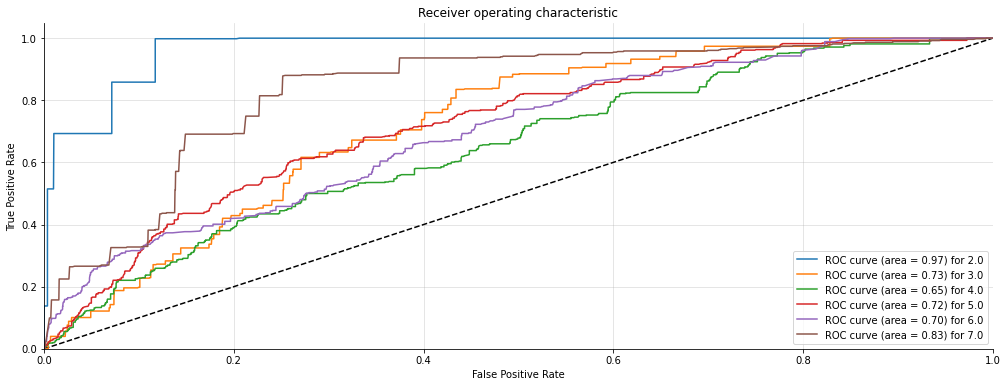

For column: easy
              precision    recall  f1-score   support

         2.0       0.67      0.86      0.75       544
         3.0       0.30      0.23      0.26       575
         4.0       0.35      0.08      0.14       589
         5.0       0.40      0.21      0.27       573
         6.0       0.27      0.44      0.34       541
         7.0       0.44      0.73      0.55       538

    accuracy                           0.42      3360
   macro avg       0.41      0.43      0.38      3360
weighted avg       0.40      0.42      0.38      3360

Confusion Matrix: 
 [[467  76   0   0   1   0]
 [118 131   9  42 150 125]
 [ 43  63  50  65 218 150]
 [ 21  43  45 119 237 108]
 [ 13  60  36  69 240 123]
 [ 33  63   1   2  45 394]]
Accuracy Score : 0.41696428571428573
Precision Score : 0.40416663961206284
Recall Score : 0.41696428571428573
F1 Score : 0.3787764558963471


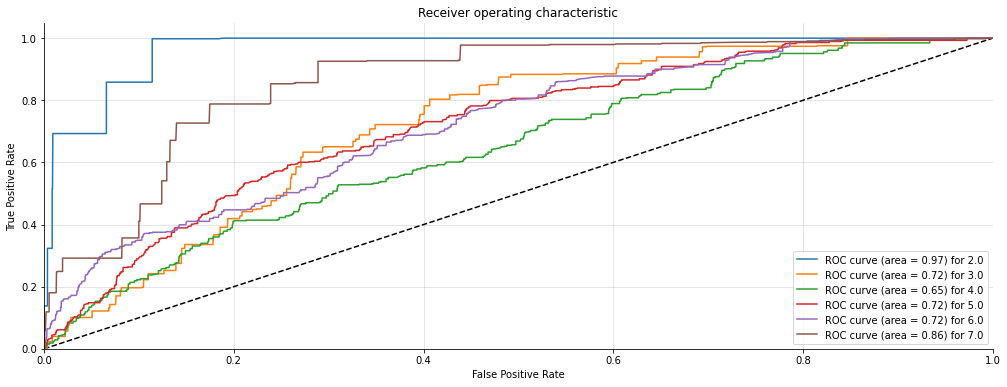

For column: efficient
              precision    recall  f1-score   support

         3.0       0.62      0.87      0.72       670
         4.0       0.39      0.16      0.22       681
         5.0       0.41      0.14      0.21       726
         6.0       0.33      0.51      0.40       639
         7.0       0.43      0.62      0.51       644

    accuracy                           0.45      3360
   macro avg       0.44      0.46      0.41      3360
weighted avg       0.44      0.45      0.41      3360

Confusion Matrix: 
 [[580  25   1  37  27]
 [152 106  43 233 147]
 [ 80  47 100 305 194]
 [ 25  43  90 325 156]
 [ 98  50   9  88 399]]
Accuracy Score : 0.4494047619047619
Precision Score : 0.4373032669112598
Recall Score : 0.4494047619047619
F1 Score : 0.40743398261398067


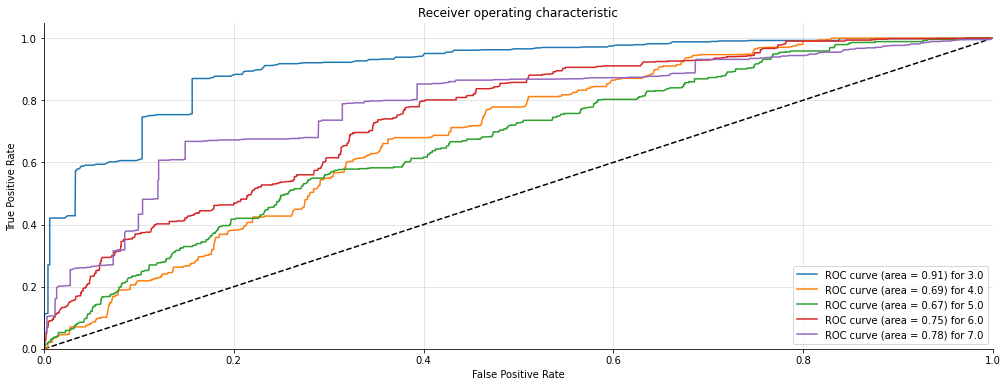

For column: clear
              precision    recall  f1-score   support

         2.0       0.66      0.86      0.75       544
         3.0       0.26      0.20      0.23       578
         4.0       0.34      0.09      0.14       595
         5.0       0.35      0.20      0.26       567
         6.0       0.25      0.41      0.31       540
         7.0       0.39      0.58      0.47       536

    accuracy                           0.38      3360
   macro avg       0.37      0.39      0.36      3360
weighted avg       0.37      0.38      0.35      3360

Confusion Matrix: 
 [[467  76   0   0   1   0]
 [118 118  17  47 150 128]
 [ 49  67  53  83 207 136]
 [ 26  45  44 115 239  98]
 [ 13  58  35  79 223 132]
 [ 31  95   5   6  86 313]]
Accuracy Score : 0.3836309523809524
Precision Score : 0.3728049782011341
Recall Score : 0.3836309523809524
F1 Score : 0.35257621531040634


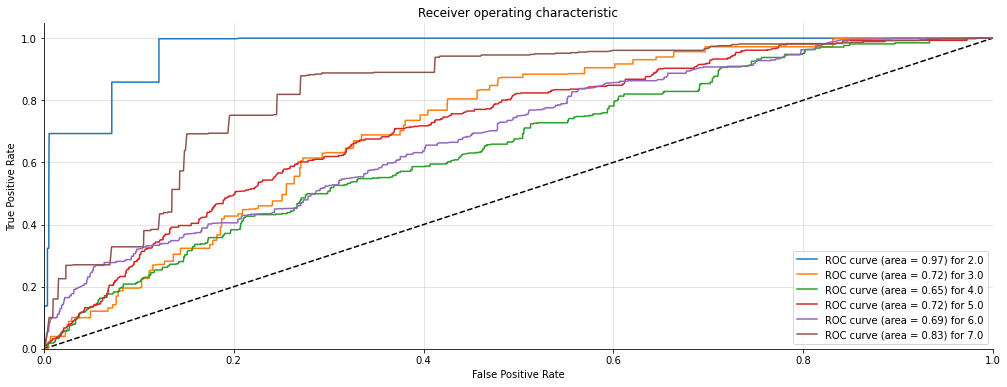

For column: exciting
              precision    recall  f1-score   support

         2.0       0.67      0.86      0.75       545
         3.0       0.32      0.25      0.28       574
         4.0       0.29      0.06      0.11       572
         5.0       0.43      0.17      0.24       602
         6.0       0.28      0.50      0.36       533
         7.0       0.44      0.75      0.56       534

    accuracy                           0.42      3360
   macro avg       0.41      0.43      0.38      3360
weighted avg       0.41      0.42      0.38      3360

Confusion Matrix: 
 [[468  76   0   0   1   0]
 [118 143  18  17 155 123]
 [ 46  68  37  60 218 143]
 [ 26  52  38 100 269 117]
 [  6  50  34  54 268 121]
 [ 32  62   1   0  39 400]]
Accuracy Score : 0.42142857142857143
Precision Score : 0.40507756516407917
Recall Score : 0.42142857142857143
F1 Score : 0.3767688112082379


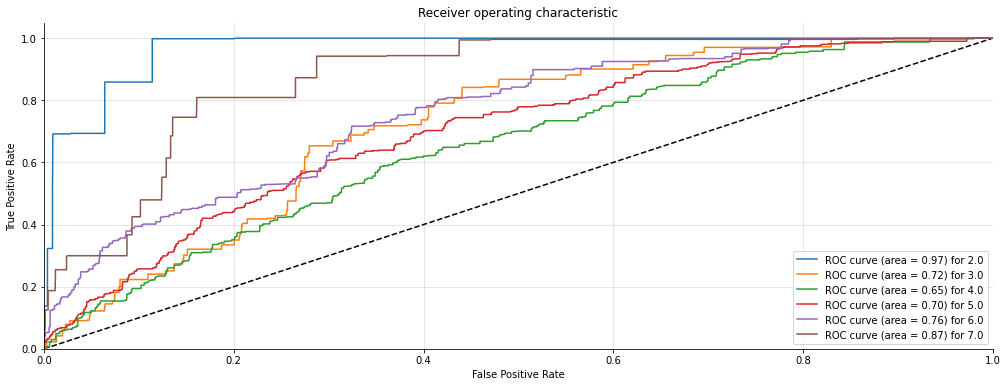

For column: interesting
              precision    recall  f1-score   support

         2.0       0.67      0.86      0.75       545
         3.0       0.31      0.23      0.26       574
         4.0       0.27      0.06      0.10       578
         5.0       0.36      0.17      0.23       592
         6.0       0.28      0.49      0.36       537
         7.0       0.44      0.75      0.56       534

    accuracy                           0.42      3360
   macro avg       0.39      0.43      0.38      3360
weighted avg       0.39      0.42      0.37      3360

Confusion Matrix: 
 [[468  76   0   0   1   0]
 [119 132  17  39 144 123]
 [ 48  57  35  78 218 142]
 [ 25  54  43 102 257 111]
 [  6  49  35  62 262 123]
 [ 32  62   1   1  38 400]]
Accuracy Score : 0.41636904761904764
Precision Score : 0.387113349901577
Recall Score : 0.41636904761904764
F1 Score : 0.3713736445061812


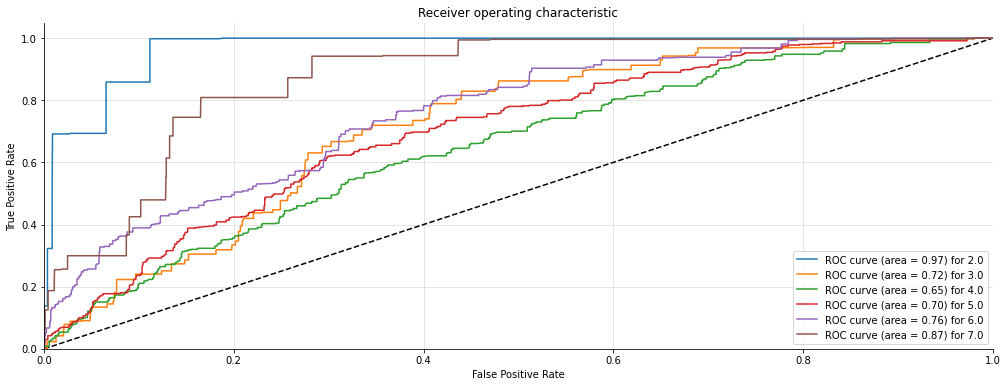

For column: inventive
              precision    recall  f1-score   support

         1.0       0.67      0.86      0.75       545
         2.0       0.30      0.23      0.26       576
         3.0       0.29      0.06      0.11       589
         4.0       0.39      0.17      0.24       586
         5.0       0.28      0.49      0.36       533
         6.0       0.44      0.76      0.56       531

    accuracy                           0.42      3360
   macro avg       0.40      0.43      0.38      3360
weighted avg       0.39      0.42      0.37      3360

Confusion Matrix: 
 [[468  76   0   0   1   0]
 [119 133  18  27 152 127]
 [ 53  63  38  79 215 141]
 [ 20  51  43 102 260 110]
 [  6  57  33  55 259 123]
 [ 32  61   0   0  37 401]]
Accuracy Score : 0.41696428571428573
Precision Score : 0.3932819202031307
Recall Score : 0.41696428571428573
F1 Score : 0.3722076511977062


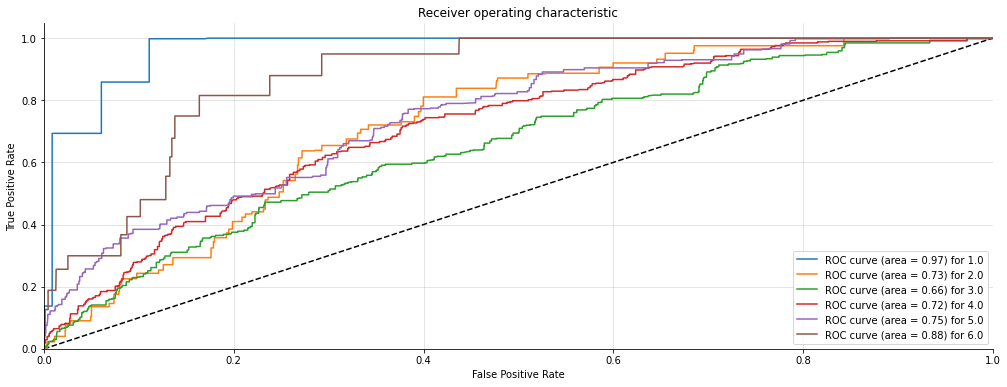

For column: leading edge
              precision    recall  f1-score   support

         1.0       0.67      0.86      0.76       544
         2.0       0.30      0.23      0.26       576
         3.0       0.30      0.06      0.10       582
         4.0       0.40      0.19      0.25       589
         5.0       0.28      0.50      0.36       536
         6.0       0.42      0.68      0.52       533

    accuracy                           0.41      3360
   macro avg       0.40      0.42      0.38      3360
weighted avg       0.39      0.41      0.37      3360

Confusion Matrix: 
 [[468  76   0   0   0   0]
 [120 133  10  39 148 126]
 [ 46  59  37  75 222 143]
 [ 23  53  44 109 252 108]
 [  6  58  32  52 270 118]
 [ 32  62   0   0  77 362]]
Accuracy Score : 0.41041666666666665
Precision Score : 0.393766695870301
Recall Score : 0.41041666666666665
F1 Score : 0.36942274286728227


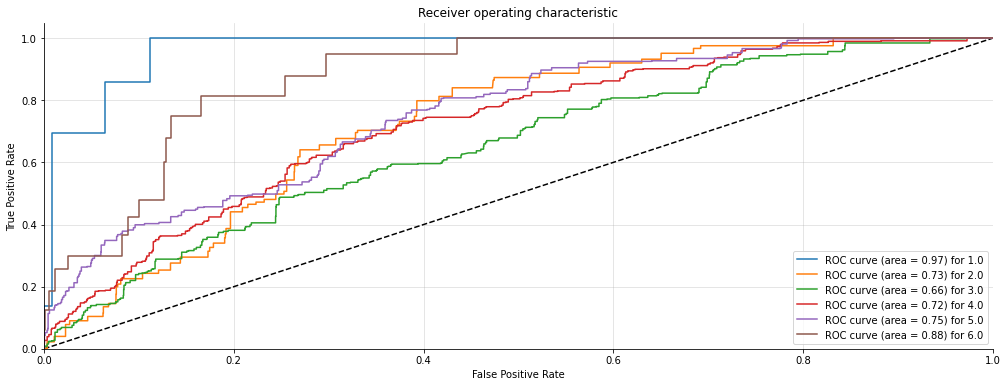

In [ ]:
from sklearn.linear_model import LogisticRegression
acc = []
pre = []
mae = []
recal = []
f1 = []
rms = []
aucscore = []
fpo = dict()
tpo = dict()
ffpo = []
ttpo = []

# Make an instance of LogisticRegression model.
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs') 

# Invoke the function from 3.5.1.
plot_all_result_model(clf, X_test, y_train, y_test,
                      ffpo, ttpo)

### 4.3.1. Average Multinomial Logistic Regression ROC

Here we plot the average ROC for each class, found with Multinomial Logistic Regression.

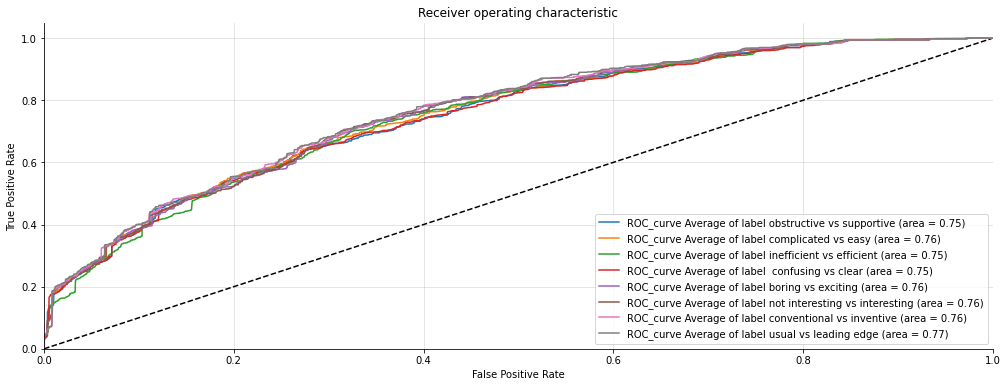

In [ ]:
plot_multiclass_roc_optim(clf, X_train, y_train, X_test, y_test)

In [ ]:
print("Average Accuracy : {}".format(np.mean(acc)))
print("Average Precision : {}".format(np.mean(pre)))
print("Average Recall : {}".format(np.mean(recal)))
print("Average F1-score : {}".format(np.mean(f1)))
print("Average RMSE score : {}".format(np.mean(rms)))
print("Average AUC score : {}".format(np.mean(aucscore)))
metric_df['LogisticModel'] = [np.mean(acc),
                              np.mean(pre), np.mean(recal), np.mean(f1),
                              np.mean(rms), np.mean(aucscore), np.mean(mae)]

Average Accuracy : 0.41171875
Average Precision : 0.395356608732512
Average Recall : 0.41171875
Average F1-score : 0.37207165923108876
Average RMSE score : 1.7162203459369199
Average AUC score : 0.6466900010997682


## 4.4 LSTM 

Long Short Term Memory networks – usually just called `“LSTMs”` – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem.

In [ ]:
# Callbacks
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_checkpoints", monitor="val_loss",
    verbose=1, save_best_only=True, mode="min")

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(4000, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are
    # very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu',
                          # Prevent overfitting
                          kernel_regularizer=tf.keras.regularizers.L2(
                              l2=0.01),
                          kernel_initializer=tf.keras.initializers.RandomNormal(
                              seed=42)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='linear')])
LSTM_model.summary()
LSTM_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=opt, metrics=['mae'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         512000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 64)                16448     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
Total params: 792,136
Trainable params: 792,136
Non-trainable params: 0
________________________________________________

In [ ]:
history = LSTM_model.fit(X_train, y_train, epochs=100,
                         batch_size=512, validation_split=0.2, 
                         callbacks=[es],
                         verbose=1)

Epoch 1/100
21/21 [==============================] - 5s 84ms/step - loss: 13.3983 - mae: 3.0659 - val_loss: 3.3809 - val_mae: 1.4924
Epoch 2/100
21/21 [==============================] - 1s 30ms/step - loss: 4.1215 - mae: 1.6364 - val_loss: 2.9511 - val_mae: 1.4268
Epoch 3/100
21/21 [==============================] - 1s 31ms/step - loss: 3.6045 - mae: 1.5431 - val_loss: 2.6733 - val_mae: 1.3674
Epoch 4/100
21/21 [==============================] - 1s 31ms/step - loss: 2.8875 - mae: 1.3634 - val_loss: 1.7285 - val_mae: 1.0212
Epoch 5/100
21/21 [==============================] - 1s 30ms/step - loss: 2.1868 - mae: 1.1153 - val_loss: 1.4085 - val_mae: 0.8812
Epoch 6/100
21/21 [==============================] - 1s 30ms/step - loss: 1.7798 - mae: 0.9732 - val_loss: 0.9341 - val_mae: 0.6629
Epoch 7/100
21/21 [==============================] - 1s 30ms/step - loss: 1.2262 - mae: 0.7721 - val_loss: 0.6104 - val_mae: 0.4724
Epoch 8/100
21/21 [==============================] - 1s 31ms/step - loss: 0

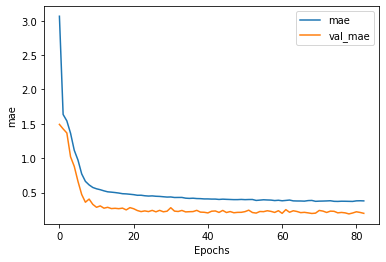

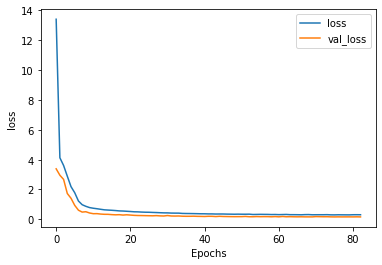

In [ ]:
plot_graphs(history, "mae")
plot_graphs(history, "loss")

### 4.4.1. Result Interpretation and Evaluation

Here we evaluate on `y_test`, which we made sure earlier comes from a similar distribution within the training set itself. 

In [ ]:
scores = LSTM_model.evaluate(
    X_test, y_test, batch_size=1, verbose=1,
    sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10,
    workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 18s 5ms/step - loss: 0.1546 - mae: 0.1930
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 15.46%
accuracy: 19.30%


### 4.4.2. List Initialization
Like before, we can initialize some empty list to keep track of the evaluation metrics we're going to use.

In [ ]:
acc = []
pre = []
recal = []
f1 = []
mae = []
rms = []
aucscore = []

In [ ]:
y_pred = LSTM_model.predict(X_test)
for i in range(8): # Loop over columns
    print("Column", df.columns[1:][i]) # Print which column we're analyzing

    # Rounding the predictions because we're approaching a problem as a regression task
    # despite we have 7 output nodes. This way, regression outputs, which would be continuous,
    # are seen as classes instead.
    estimates = [round(float(x)) for x in y_pred[:, i]] 
    estimates = transform_results(estimates)

    # print(np.unique(estimates)) # Uncomment to see the unique classes in that column
    print(classification_report(y_test[:, i], estimates), "\n------") # Print classification report

    # Append all the scores to our previously initialized list
    acc.append(accuracy_score(y_test[:, i], estimates))
    pre.append(precision_score(y_test[:, i], estimates, average='weighted'))
    recall.append(recall_score(y_test[:, i], estimates, average='weighted'))
    f1.append(f1_score(y_test[:, i], estimates, average='weighted'))
    rms.append(np.sqrt(mean_squared_error(y_test[:, i], estimates)))
    aucscore.append(score_auc(y_test[:, i], estimates))
    mae.append(mean_absolute_error(y_test[:, i], estimates))

Column supportive
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.98      0.98      0.98       576
         4.0       0.88      0.83      0.85       594
         5.0       0.72      0.77      0.75       571
         6.0       0.75      0.75      0.75       541
         7.0       0.91      0.90      0.91       534

    accuracy                           0.87      3360
   macro avg       0.87      0.87      0.87      3360
weighted avg       0.87      0.87      0.87      3360
 
------
Column easy
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.98      0.98      0.98       575
         4.0       0.89      0.87      0.88       589
         5.0       0.78      0.80      0.79       573
         6.0       0.82      0.82      0.82       541
         7.0       0.98      0.97      0.97       538

    accuracy                           

In [ ]:
print("Average Accuracy : {}".format(np.mean(acc)))
print("Average Precision : {}".format(np.mean(pre)))
print("Average Recall : {}".format(np.mean(recal)))
print("Average F1 score : {}".format(np.mean(f1)))
print("Average RMSE score : {}".format(np.mean(rms)))
print("Average AUC score : {}".format(np.mean(aucscore)))
metric_df['LSTM'] = [np.mean(acc),
                                     np.mean(pre), np.mean(recal),
                                     np.mean(f1), np.mean(rms),
                                     np.mean(aucscore), np.mean(mae)]

Average Accuracy : 0.9090029761904762
Average Precision : 0.9133378566809738
Average Recall : nan
Average F1 score : 0.9099493887898195
Average RMSE score : 0.34899094443932777
Average AUC score : 0.9444715991741285


## 4.5 Ensemble

In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

In this project, ensemble algorithms we can try out are as follows:
1. Random Forest
2. Extra Trees
3. AdaBoost
4. Bagging Classifier

We've already implemented gradient boosting via XGB on Section 3.5., so we think it's redundant to implement it all over again.

In [ ]:
# Import modules
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier

### 4.5.1 Random Forest Classifier

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees.

For column: supportive
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.98      0.98      0.98       576
         4.0       0.85      0.88      0.86       594
         5.0       0.75      0.71      0.73       571
         6.0       0.74      0.75      0.74       541
         7.0       0.90      0.90      0.90       534

    accuracy                           0.87      3360
   macro avg       0.87      0.87      0.87      3360
weighted avg       0.87      0.87      0.87      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 564  12   0   0   0]
 [  0   2 524  61   5   2]
 [  0   1  42 403 123   2]
 [  0   6  31  51 404  49]
 [  1   4  10  21  15 483]]
Accuracy Score : 0.8693452380952381
Precision Score : 0.868442527371826
Recall Score : 0.8693452380952381
F1 Score : 0.8687005235888489


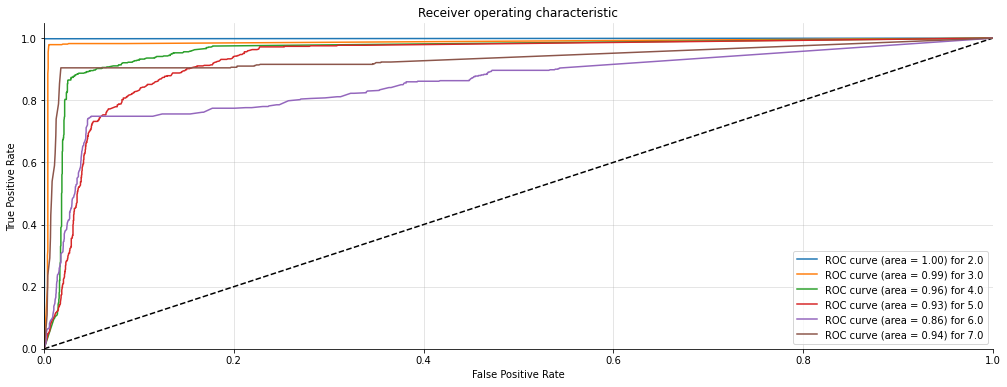

For column: easy
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.97      0.98      0.98       575
         4.0       0.86      0.89      0.87       589
         5.0       0.80      0.75      0.77       573
         6.0       0.81      0.82      0.82       541
         7.0       0.97      0.97      0.97       538

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 564  11   0   0   0]
 [  0   2 525  58   3   1]
 [  0   3  40 432  97   1]
 [  0  10  33  42 444  12]
 [  1   0   3  11   3 520]]
Accuracy Score : 0.9011904761904762
Precision Score : 0.9006844857683891
Recall Score : 0.9011904761904762
F1 Score : 0.9007764858079118


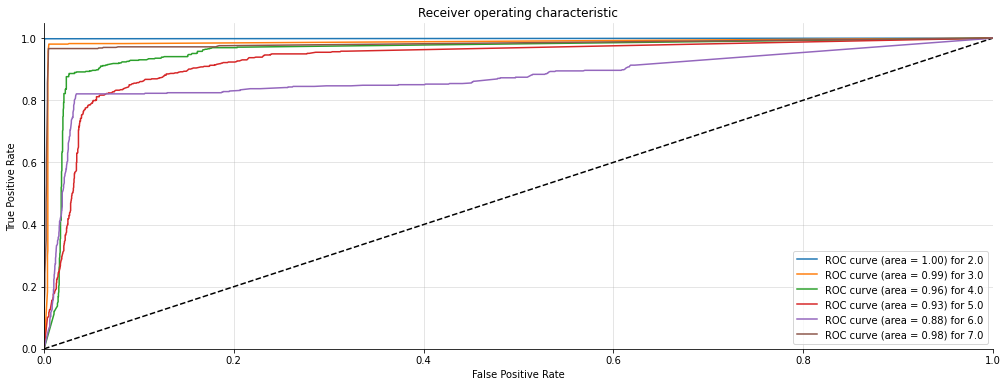

For column: efficient
              precision    recall  f1-score   support

         3.0       1.00      0.81      0.89       670
         4.0       0.66      0.78      0.71       681
         5.0       0.62      0.73      0.67       726
         6.0       0.76      0.73      0.75       639
         7.0       0.97      0.82      0.89       644

    accuracy                           0.77      3360
   macro avg       0.80      0.77      0.78      3360
weighted avg       0.80      0.77      0.78      3360

Confusion Matrix: 
 [[543 127   0   0   0]
 [  0 531 147   2   1]
 [  0 124 530  64   8]
 [  0  17 151 466   5]
 [  1  10  23  80 530]]
Accuracy Score : 0.7738095238095238
Precision Score : 0.7981813257809871
Recall Score : 0.7738095238095238
F1 Score : 0.7807742831017614


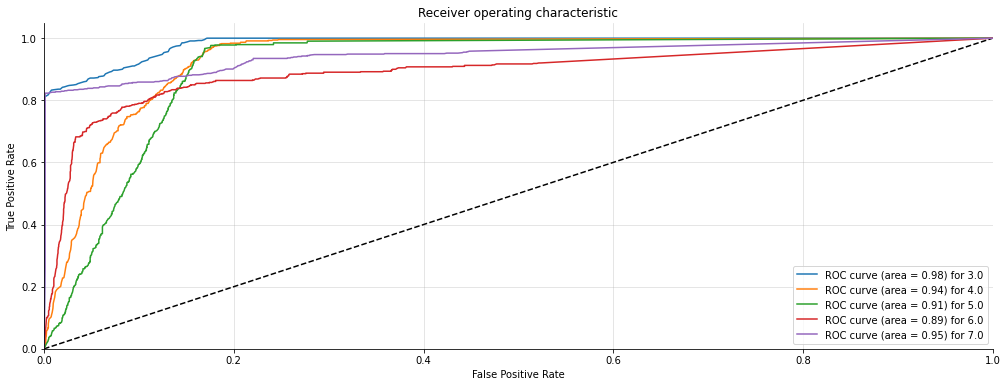

For column: clear
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.98      0.98      0.98       578
         4.0       0.86      0.88      0.87       595
         5.0       0.75      0.73      0.74       567
         6.0       0.75      0.76      0.75       540
         7.0       0.91      0.91      0.91       536

    accuracy                           0.87      3360
   macro avg       0.87      0.87      0.87      3360
weighted avg       0.87      0.87      0.87      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 564  12   2   0   0]
 [  0   2 524  64   4   1]
 [  0   1  30 412 122   2]
 [  1   6  27  53 408  45]
 [  0   4  16  20   9 487]]
Accuracy Score : 0.8744047619047619
Precision Score : 0.873980316093832
Recall Score : 0.8744047619047619
F1 Score : 0.8741451611158875


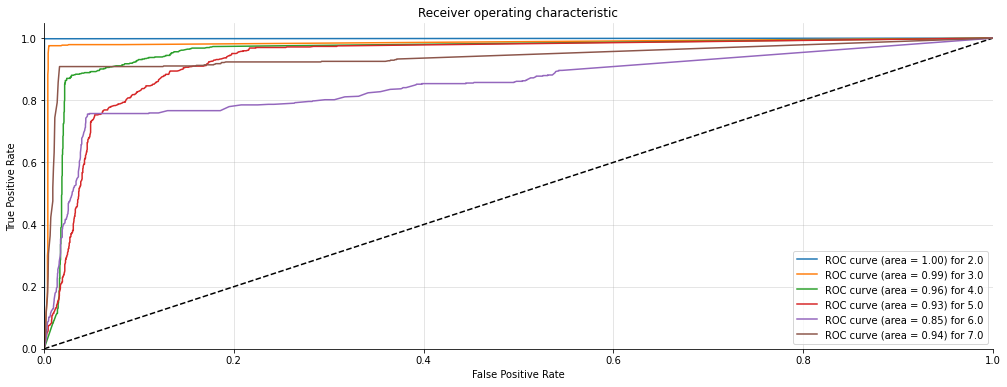

For column: exciting
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       545
         3.0       0.97      0.97      0.97       574
         4.0       0.86      0.88      0.87       572
         5.0       0.88      0.84      0.86       602
         6.0       0.93      0.95      0.94       533
         7.0       0.99      0.99      0.99       534

    accuracy                           0.94      3360
   macro avg       0.94      0.94      0.94      3360
weighted avg       0.94      0.94      0.94      3360

Confusion Matrix: 
 [[543   1   0   1   0   0]
 [  1 558   6   6   3   0]
 [  0  18 506  39   8   1]
 [  0   1  75 505  20   1]
 [  0   0   2  25 504   2]
 [  0   0   0   0   5 529]]
Accuracy Score : 0.9360119047619048
Precision Score : 0.9359483502002582
Recall Score : 0.9360119047619048
F1 Score : 0.935864823705696


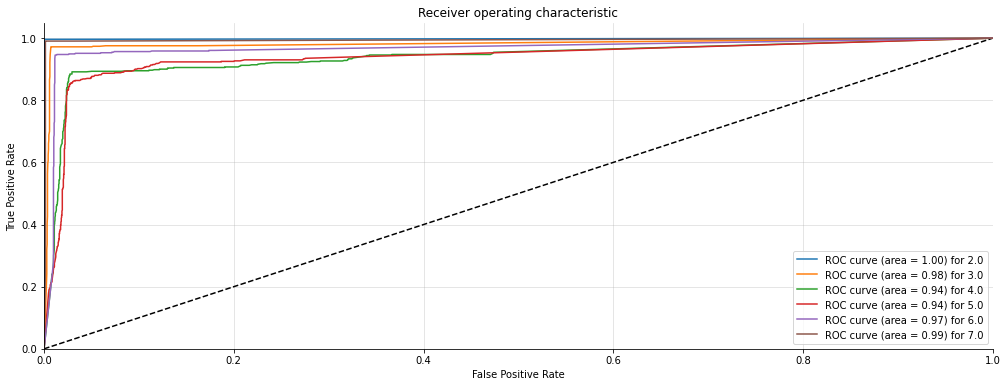

For column: interesting
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       545
         3.0       0.97      0.97      0.97       574
         4.0       0.89      0.90      0.90       578
         5.0       0.89      0.87      0.88       592
         6.0       0.94      0.94      0.94       537
         7.0       0.99      0.99      0.99       534

    accuracy                           0.94      3360
   macro avg       0.95      0.95      0.95      3360
weighted avg       0.94      0.94      0.94      3360

Confusion Matrix: 
 [[543   1   0   1   0   0]
 [  1 558   8   5   2   0]
 [  0  19 521  29   8   1]
 [  0   0  56 516  19   1]
 [  0   0   1  28 506   2]
 [  0   0   0   0   5 529]]
Accuracy Score : 0.9443452380952381
Precision Score : 0.9442829816991943
Recall Score : 0.9443452380952381
F1 Score : 0.9442842606026127


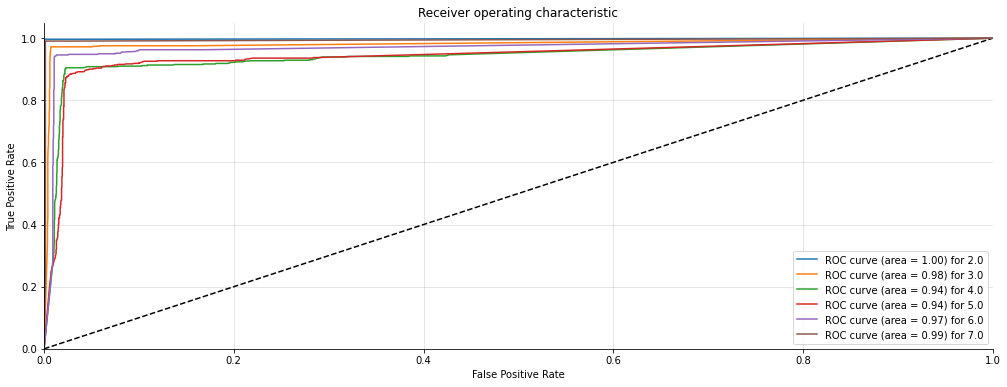

For column: inventive
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       545
         2.0       0.99      1.00      0.99       576
         3.0       0.96      0.95      0.96       589
         4.0       0.94      0.93      0.94       586
         5.0       0.97      0.98      0.97       533
         6.0       1.00      1.00      1.00       531

    accuracy                           0.98      3360
   macro avg       0.98      0.98      0.98      3360
weighted avg       0.98      0.98      0.98      3360

Confusion Matrix: 
 [[544   1   0   0   0   0]
 [  0 574   2   0   0   0]
 [  0   3 562  23   1   0]
 [  0   0  22 547  17   0]
 [  0   0   0   9 522   2]
 [  0   0   0   0   0 531]]
Accuracy Score : 0.9761904761904762
Precision Score : 0.9761145648926977
Recall Score : 0.9761904761904762
F1 Score : 0.9761377390951697


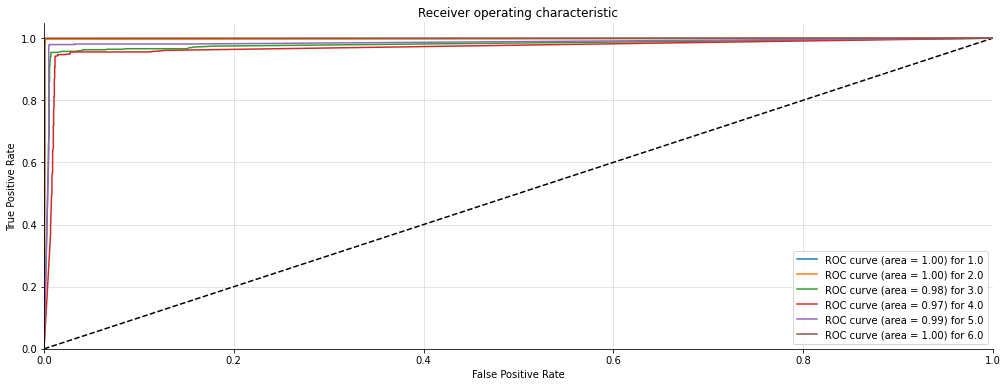

For column: leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       544
         2.0       1.00      1.00      1.00       576
         3.0       1.00      1.00      1.00       582
         4.0       1.00      0.99      1.00       589
         5.0       1.00      1.00      1.00       536
         6.0       1.00      1.00      1.00       533

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[544   0   0   0   0   0]
 [  0 576   0   0   0   0]
 [  0   2 580   0   0   0]
 [  0   0   2 586   1   0]
 [  0   0   0   0 536   0]
 [  0   0   0   0   0 533]]
Accuracy Score : 0.9985119047619048
Precision Score : 0.9985145186347079
Recall Score : 0.9985119047619048
F1 Score : 0.9985114194340012


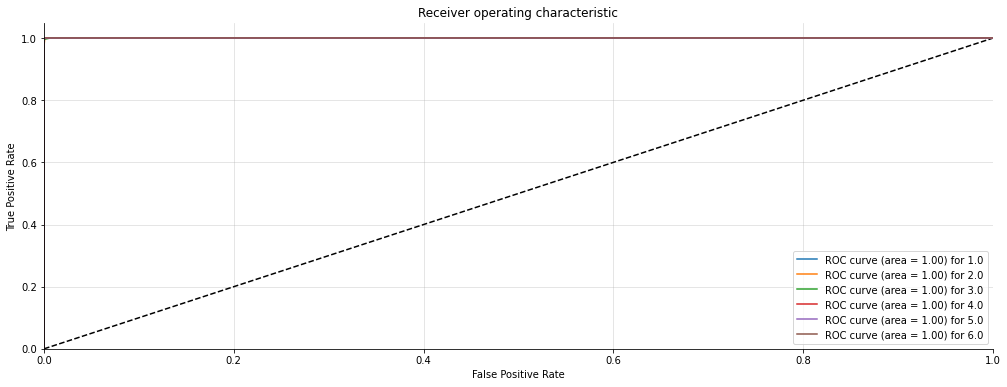

In [ ]:
acc = []
pre = []
recal = []
f1 = []
mae = []
rms = []
aucscore = []
fpo = dict()
tpo = dict()
ffpo = []
ttpo = []

# Make a RandomForestClassifier object with 100 trees
clf = RandomForestClassifier(n_estimators=100, max_depth=None, 
                                   min_samples_split=2, random_state=0)
# Invoke the function from 3.5.1.
plot_all_result_model(clf, X_test, y_train, y_test,
                      ffpo, ttpo)

#### 4.5.1.1. Average Random Forest ROC

Here we plot the average ROC for each class, found with our Random Forest.

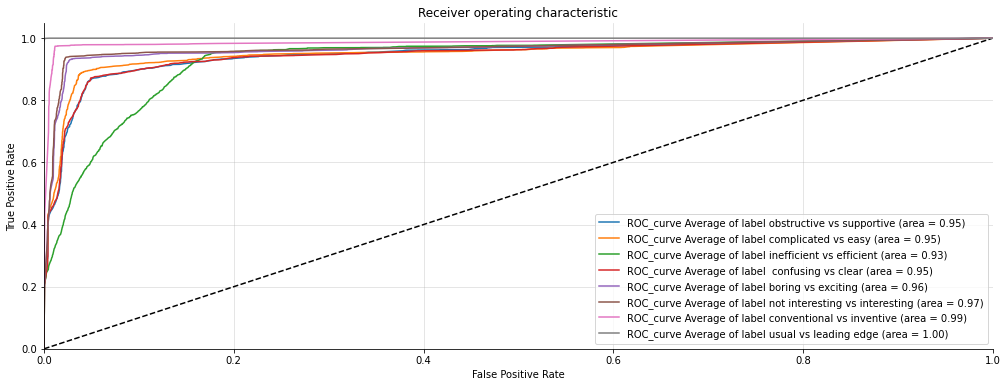

In [ ]:
plot_multiclass_roc_optim(clf,X_train, y_train, X_test, y_test)

In [ ]:
print("Average Accuracy : {}".format(np.mean(acc)))
print("Average Precision : {}".format(np.mean(pre)))
print("Average Recall : {}".format(np.mean(recal)))
print("Average F1 score : {}".format(np.mean(f1)))
print("Average RMSE score : {}".format(np.mean(rms)))
print("Average AUC score : {}".format(np.mean(aucscore)))
metric_df['RandomForestClassifier'] = [np.mean(acc),
                                       np.mean(pre), np.mean(recal),
                                       np.mean(f1), np.mean(rms),
                                       np.mean(aucscore), np.mean(mae)]

Average Accuracy : 0.9092261904761905
Average Precision : 0.9120186338052365
Average Recall : 0.9092261904761905
Average F1 score : 0.9098993370564862
Average RMSE score : 0.3453807790900732
Average AUC score : 0.9446172394821493


### 4.5.2 Extra Trees Classifier

Extremely Randomized (abbreviated *Extra*) Trees Classifier is a type of ensemble learning technique which aggregates the results of multiple de-correlated decision trees collected in a “forest” to output it's classification result.

For column: supportive
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.98      0.98      0.98       576
         4.0       0.83      0.88      0.86       594
         5.0       0.75      0.71      0.73       571
         6.0       0.75      0.74      0.75       541
         7.0       0.90      0.90      0.90       534

    accuracy                           0.87      3360
   macro avg       0.87      0.87      0.87      3360
weighted avg       0.87      0.87      0.87      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 564  12   0   0   0]
 [  0   2 525  61   4   2]
 [  0   1  51 404 114   1]
 [  0   6  32  51 403  49]
 [  1   4  10  21  15 483]]
Accuracy Score : 0.8696428571428572
Precision Score : 0.8685964615820432
Recall Score : 0.8696428571428572
F1 Score : 0.8688683272105688


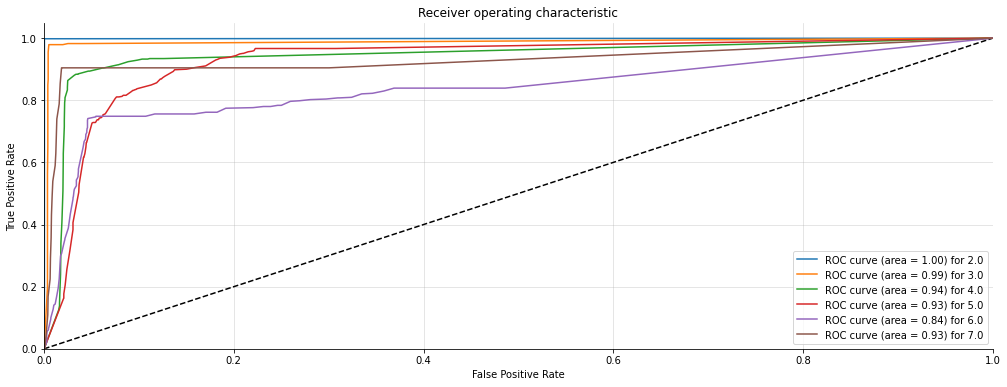

For column: easy
              precision    recall  f1-score   support

         2.0       0.99      1.00      1.00       544
         3.0       0.97      0.98      0.98       575
         4.0       0.84      0.89      0.87       589
         5.0       0.79      0.73      0.76       573
         6.0       0.82      0.82      0.82       541
         7.0       0.97      0.97      0.97       538

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 564  11   0   0   0]
 [  0   2 526  58   2   1]
 [  2   4  54 421  91   1]
 [  0  10  33  42 444  12]
 [  1   0   3  11   3 520]]
Accuracy Score : 0.8982142857142857
Precision Score : 0.8974614888520085
Recall Score : 0.8982142857142857
F1 Score : 0.8975031779394473


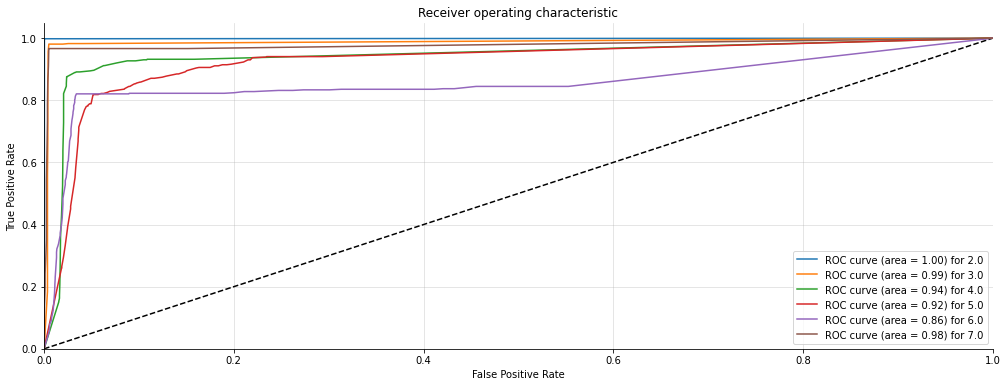

For column: efficient
              precision    recall  f1-score   support

         3.0       1.00      0.81      0.89       670
         4.0       0.64      0.80      0.71       681
         5.0       0.62      0.72      0.67       726
         6.0       0.78      0.72      0.75       639
         7.0       0.98      0.82      0.90       644

    accuracy                           0.77      3360
   macro avg       0.81      0.77      0.78      3360
weighted avg       0.80      0.77      0.78      3360

Confusion Matrix: 
 [[543 127   0   0   0]
 [  0 545 133   2   1]
 [  0 152 525  45   4]
 [  0  19 158 458   4]
 [  1  10  24  79 530]]
Accuracy Score : 0.7741071428571429
Precision Score : 0.8011917283358213
Recall Score : 0.7741071428571429
F1 Score : 0.7814491679349392


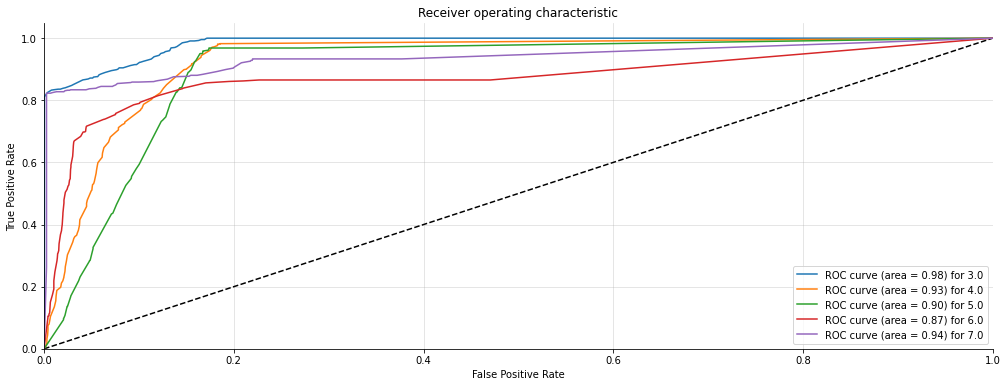

For column: clear
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.98      0.98      0.98       578
         4.0       0.85      0.88      0.86       595
         5.0       0.75      0.72      0.74       567
         6.0       0.76      0.76      0.76       540
         7.0       0.91      0.91      0.91       536

    accuracy                           0.87      3360
   macro avg       0.87      0.87      0.87      3360
weighted avg       0.87      0.87      0.87      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 564  12   2   0   0]
 [  0   2 525  64   3   1]
 [  0   1  38 410 117   1]
 [  1   6  28  52 408  45]
 [  0   4  17  19   9 487]]
Accuracy Score : 0.8741071428571429
Precision Score : 0.8734895250118624
Recall Score : 0.8741071428571429
F1 Score : 0.8736920128714736


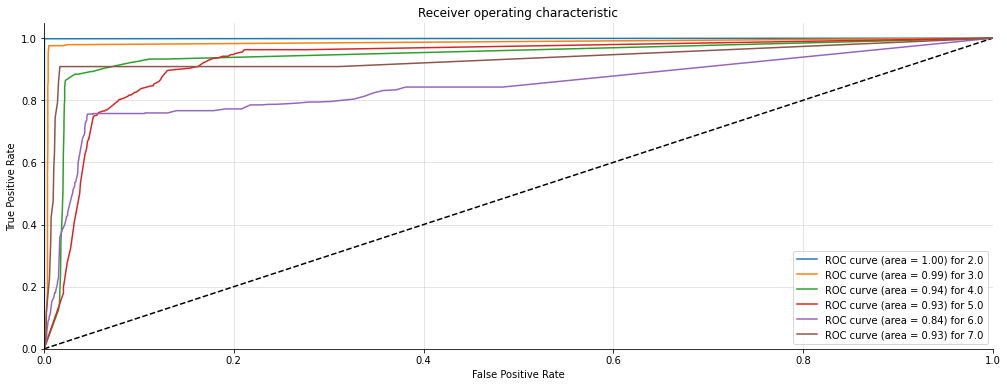

For column: exciting
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       545
         3.0       0.96      0.97      0.97       574
         4.0       0.85      0.89      0.87       572
         5.0       0.88      0.83      0.86       602
         6.0       0.94      0.95      0.94       533
         7.0       0.99      0.99      0.99       534

    accuracy                           0.94      3360
   macro avg       0.94      0.94      0.94      3360
weighted avg       0.94      0.94      0.94      3360

Confusion Matrix: 
 [[543   1   0   1   0   0]
 [  1 558   6   6   3   0]
 [  0  18 510  35   8   1]
 [  0   2  82 500  17   1]
 [  0   0   2  25 504   2]
 [  0   0   0   0   5 529]]
Accuracy Score : 0.9357142857142857
Precision Score : 0.9358577416104952
Recall Score : 0.9357142857142857
F1 Score : 0.9355584160849966


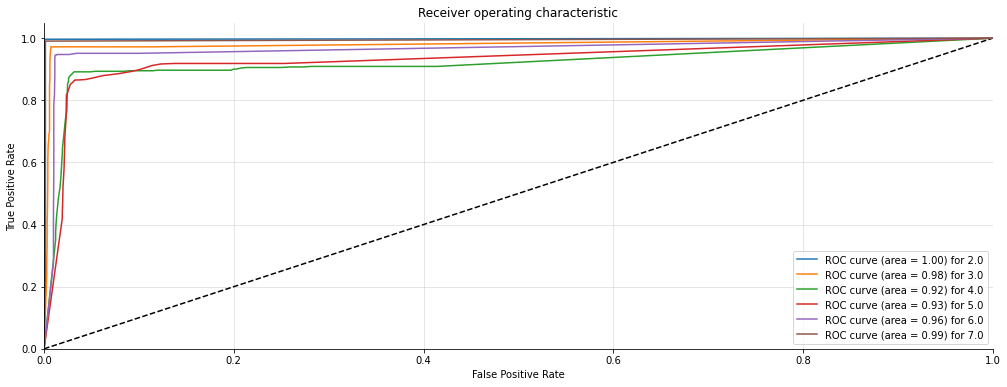

For column: interesting
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       545
         3.0       0.96      0.97      0.97       574
         4.0       0.87      0.90      0.89       578
         5.0       0.89      0.85      0.87       592
         6.0       0.94      0.94      0.94       537
         7.0       0.99      0.99      0.99       534

    accuracy                           0.94      3360
   macro avg       0.94      0.94      0.94      3360
weighted avg       0.94      0.94      0.94      3360

Confusion Matrix: 
 [[543   1   0   1   0   0]
 [  1 558   8   5   2   0]
 [  0  19 523  27   8   1]
 [  0   3  67 505  16   1]
 [  0   0   1  28 506   2]
 [  0   0   0   0   5 529]]
Accuracy Score : 0.9416666666666667
Precision Score : 0.9417053827682215
Recall Score : 0.9416666666666667
F1 Score : 0.9415534972512043


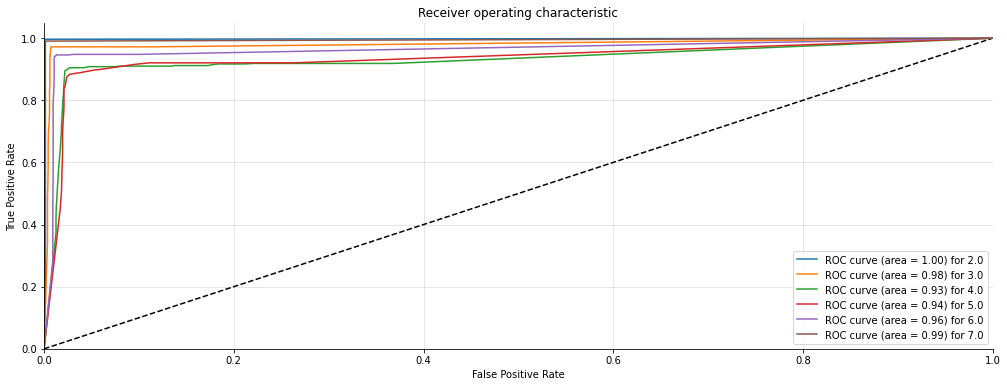

For column: inventive
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       545
         2.0       0.99      1.00      0.99       576
         3.0       0.96      0.95      0.96       589
         4.0       0.95      0.94      0.94       586
         5.0       0.97      0.98      0.98       533
         6.0       1.00      1.00      1.00       531

    accuracy                           0.98      3360
   macro avg       0.98      0.98      0.98      3360
weighted avg       0.98      0.98      0.98      3360

Confusion Matrix: 
 [[544   1   0   0   0   0]
 [  0 574   2   0   0   0]
 [  0   3 562  23   1   0]
 [  0   0  22 550  14   0]
 [  0   0   0   9 522   2]
 [  0   0   0   0   0 531]]
Accuracy Score : 0.9770833333333333
Precision Score : 0.9770209164282088
Recall Score : 0.9770833333333333
F1 Score : 0.9770457360895483


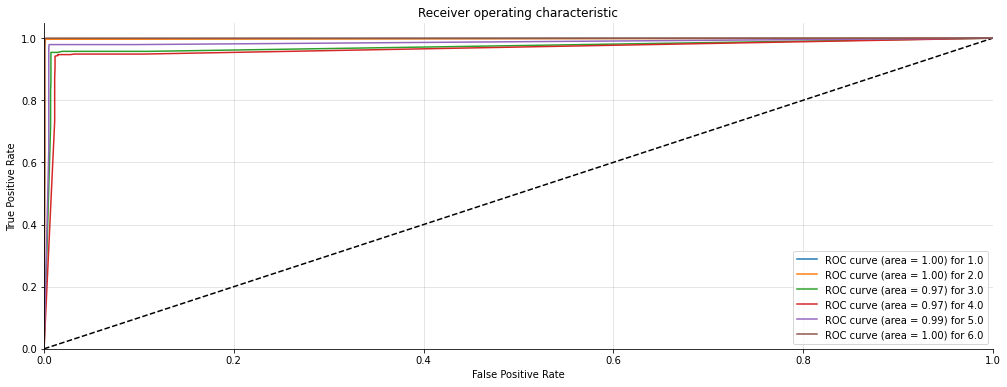

For column: leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       544
         2.0       1.00      1.00      1.00       576
         3.0       1.00      1.00      1.00       582
         4.0       1.00      0.99      1.00       589
         5.0       1.00      1.00      1.00       536
         6.0       1.00      1.00      1.00       533

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[544   0   0   0   0   0]
 [  0 576   0   0   0   0]
 [  0   2 580   0   0   0]
 [  0   0   2 586   1   0]
 [  0   0   0   0 536   0]
 [  0   0   0   0   0 533]]
Accuracy Score : 0.9985119047619048
Precision Score : 0.9985145186347079
Recall Score : 0.9985119047619048
F1 Score : 0.9985114194340012


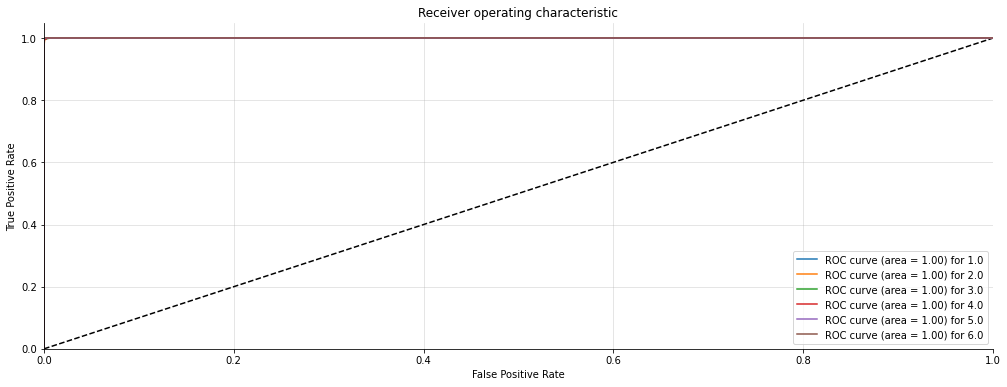

In [ ]:
# As usual, initialize empty lists to record metrics
acc = []
pre = []
recal = []
mae = []
f1 = []
rms = []
aucscore = []
fpo = dict()
tpo = dict()
ffpo = []
ttpo = []

# Make a ExtraTreesClassifier object with 100 trees
clf = ExtraTreesClassifier(n_estimators=100, max_depth=None,
                                 min_samples_split=2, random_state=0)

# Invoke the function from 3.5.1.
plot_all_result_model(clf, X_test, y_train, y_test,
                      ffpo, ttpo)

#### 4.5.2.1. Average Extra Trees Classifier ROC

Here we plot the average ROC for each class, found with our Extra Trees Classifier.

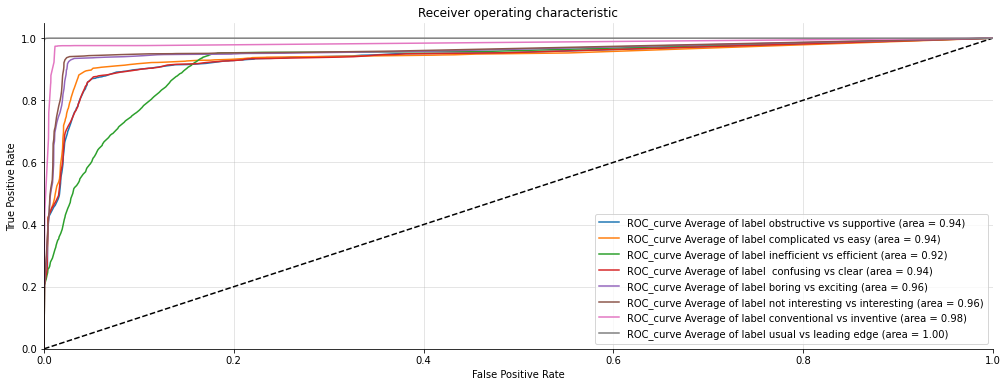

In [ ]:
plot_multiclass_roc_optim(clf  ,X_train, y_train, X_test, y_test)

In [ ]:
print("Average Accuracy : {}".format(np.mean(acc)))
print("Average Precision : {}".format(np.mean(pre)))
print("Average Recall : {}".format(np.mean(recal)))
print("Average F1-score : {}".format(np.mean(f1)))
print("Average RMSE score : {}".format(np.mean(rms)))
print("Average AUC score : {}".format(np.mean(aucscore)))
metric_df['ExtraTreesClassifier'] = [np.mean(acc),np.mean(pre),
                                     np.mean(recal),np.mean(f1),
                                     np.mean(rms),np.mean(aucscore),
                                     np.mean(mae)]

Average Accuracy : 0.9086309523809524
Average Precision : 0.9117297204029211
Average Recall : 0.9086309523809524
Average F1-score : 0.9092727193520225
Average RMSE score : 0.3473821464194616
Average AUC score : 0.9442395493364211


### 4.5.3 AdaBoost 

AdaBoost, short for Adaptive Boosting, is a statistical classification meta-algorithm formulated by Yoav Freund and Robert Schapire, who won the 2003 Gödel Prize for their work. It can be used in conjunction with many other types of learning algorithms to improve performance.

For column: supportive
              precision    recall  f1-score   support

         2.0       0.98      0.86      0.91       544
         3.0       0.73      0.16      0.27       576
         4.0       0.26      0.19      0.22       594
         5.0       0.22      0.75      0.34       571
         6.0       0.18      0.09      0.12       541
         7.0       0.34      0.05      0.09       534

    accuracy                           0.35      3360
   macro avg       0.45      0.35      0.32      3360
weighted avg       0.45      0.35      0.32      3360

Confusion Matrix: 
 [[468   0   0  76   0   0]
 [ 10  95  84 290  97   0]
 [  0  14 112 396  50  22]
 [  0  13  76 426  40  16]
 [  0   8  65 405  48  15]
 [  1   1  98 373  34  27]]
Accuracy Score : 0.35
Precision Score : 0.44721482901417703
Recall Score : 0.35
F1 Score : 0.32282099970032646


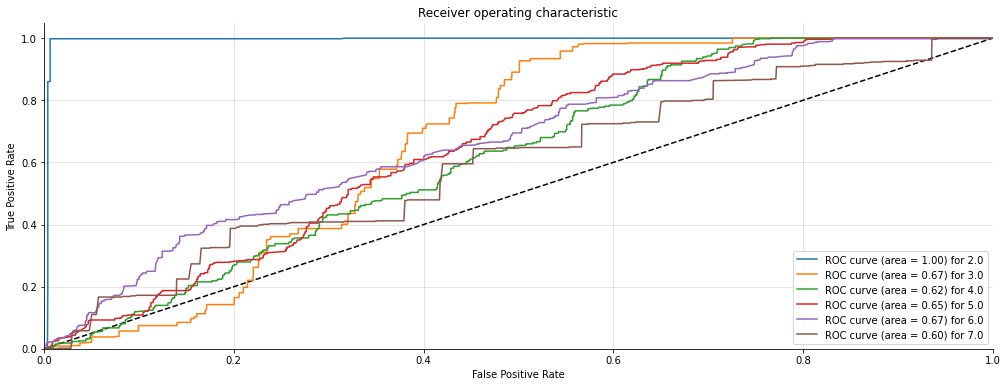

For column: easy
              precision    recall  f1-score   support

         2.0       1.00      0.67      0.80       544
         3.0       0.68      0.21      0.33       575
         4.0       0.22      0.09      0.13       589
         5.0       0.22      0.84      0.35       573
         6.0       0.05      0.03      0.03       541
         7.0       0.19      0.06      0.09       538

    accuracy                           0.32      3360
   macro avg       0.39      0.32      0.29      3360
weighted avg       0.39      0.32      0.29      3360

Confusion Matrix: 
 [[367   0   0  76 101   0]
 [  0 123  59 301  41  51]
 [  0  24  52 452  33  28]
 [  0  15  38 479  24  17]
 [  0  19  13 464  14  31]
 [  1   0  73 374  60  30]]
Accuracy Score : 0.3169642857142857
Precision Score : 0.39346507904740946
Recall Score : 0.3169642857142857
F1 Score : 0.2875628320820745


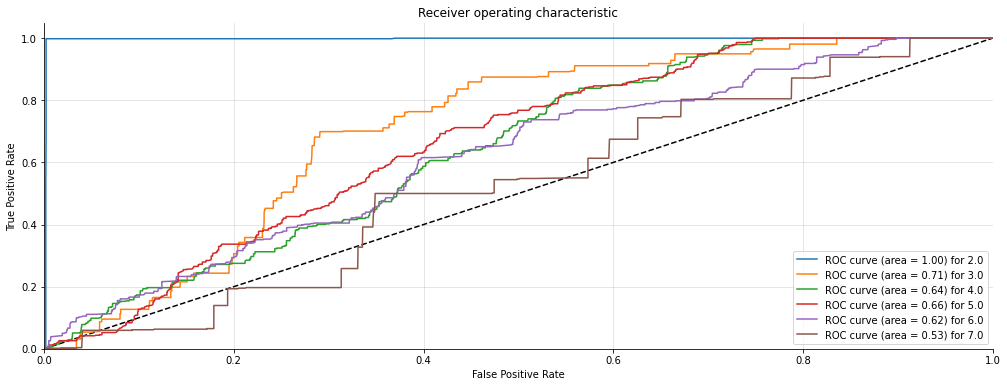

For column: efficient
              precision    recall  f1-score   support

         3.0       0.92      0.71      0.80       670
         4.0       0.54      0.66      0.59       681
         5.0       0.38      0.39      0.38       726
         6.0       0.43      0.36      0.39       639
         7.0       0.53      0.61      0.57       644

    accuracy                           0.54      3360
   macro avg       0.56      0.54      0.55      3360
weighted avg       0.56      0.54      0.55      3360

Confusion Matrix: 
 [[477 112  75   2   4]
 [ 25 450  94  57  55]
 [  7 145 282 139 153]
 [  7  70 202 227 133]
 [  2  57  92 103 390]]
Accuracy Score : 0.5434523809523809
Precision Score : 0.5582318706694142
Recall Score : 0.5434523809523809
F1 Score : 0.5457730825548951


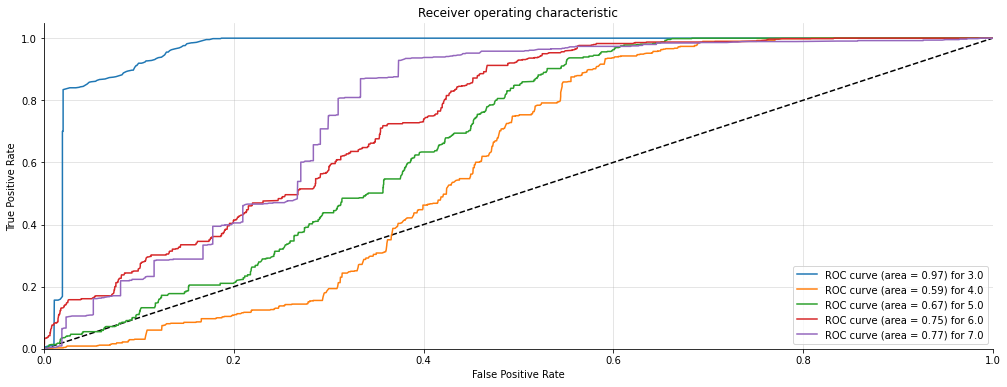

For column: clear
              precision    recall  f1-score   support

         2.0       0.98      0.86      0.91       544
         3.0       0.40      0.35      0.37       578
         4.0       0.20      0.29      0.24       595
         5.0       0.23      0.42      0.30       567
         6.0       0.20      0.14      0.16       540
         7.0       0.43      0.10      0.16       536

    accuracy                           0.36      3360
   macro avg       0.41      0.36      0.36      3360
weighted avg       0.40      0.36      0.36      3360

Confusion Matrix: 
 [[468   1   0  75   0   0]
 [ 10 204  87 191  64  22]
 [  0  92 170 252  67  14]
 [  0  70 188 237  54  18]
 [  1  68 177 203  73  18]
 [  0  78 227  75 102  54]]
Accuracy Score : 0.35892857142857143
Precision Score : 0.40172496057877294
Recall Score : 0.35892857142857143
F1 Score : 0.35625144917228696


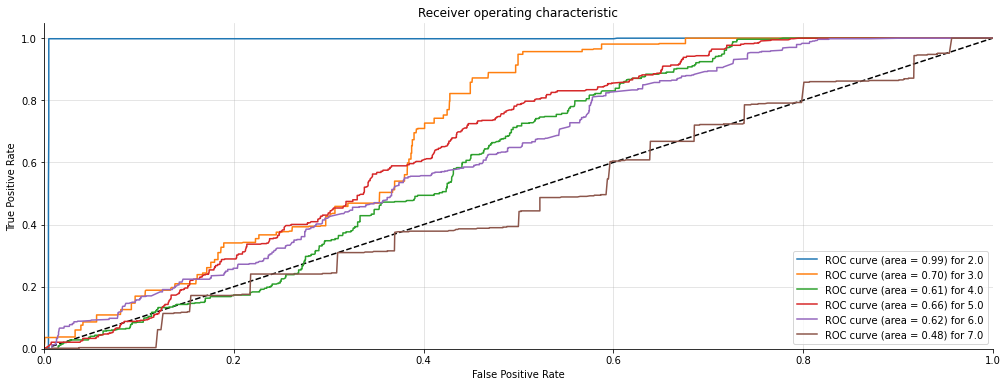

For column: exciting
              precision    recall  f1-score   support

         2.0       0.86      0.48      0.62       545
         3.0       0.40      0.47      0.43       574
         4.0       0.17      0.13      0.15       572
         5.0       0.19      0.19      0.19       602
         6.0       0.23      0.44      0.31       533
         7.0       0.32      0.19      0.24       534

    accuracy                           0.32      3360
   macro avg       0.36      0.32      0.32      3360
weighted avg       0.36      0.32      0.32      3360

Confusion Matrix: 
 [[264   0 206  75   0   0]
 [ 17 270  37 100 150   0]
 [ 14 135  74 120 175  54]
 [  5 107  37 116 243  94]
 [  8  99  10 113 234  69]
 [  0  71  71  96 195 101]]
Accuracy Score : 0.3151785714285714
Precision Score : 0.3568527766529385
Recall Score : 0.3151785714285714
F1 Score : 0.3190874249896289


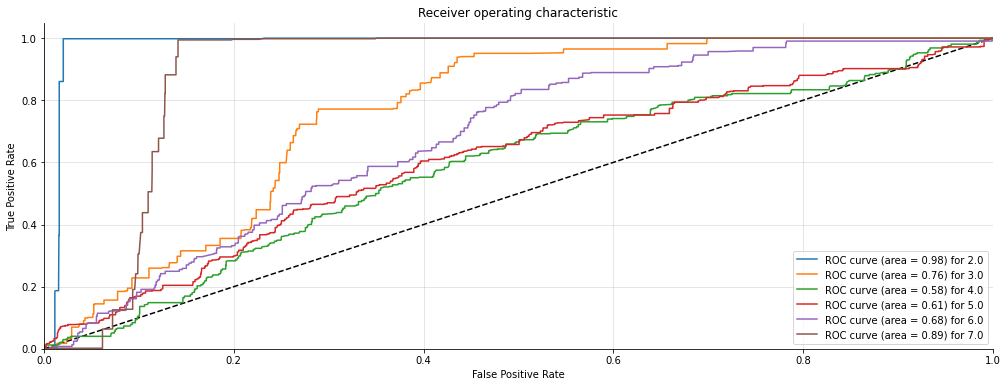

For column: interesting
              precision    recall  f1-score   support

         2.0       0.96      0.48      0.64       545
         3.0       0.32      0.54      0.40       574
         4.0       0.20      0.12      0.15       578
         5.0       0.26      0.16      0.20       592
         6.0       0.27      0.28      0.27       537
         7.0       0.18      0.29      0.22       534

    accuracy                           0.31      3360
   macro avg       0.37      0.31      0.32      3360
weighted avg       0.36      0.31      0.31      3360

Confusion Matrix: 
 [[263 105 102  75   0   0]
 [ 11 312  29  47  78  97]
 [  0 180  69  83  78 168]
 [  0 124  49  97 106 216]
 [  0  91  19  73 149 205]
 [  0 172  71   1 136 154]]
Accuracy Score : 0.3107142857142857
Precision Score : 0.3629958068746841
Recall Score : 0.3107142857142857
F1 Score : 0.31335593610141577


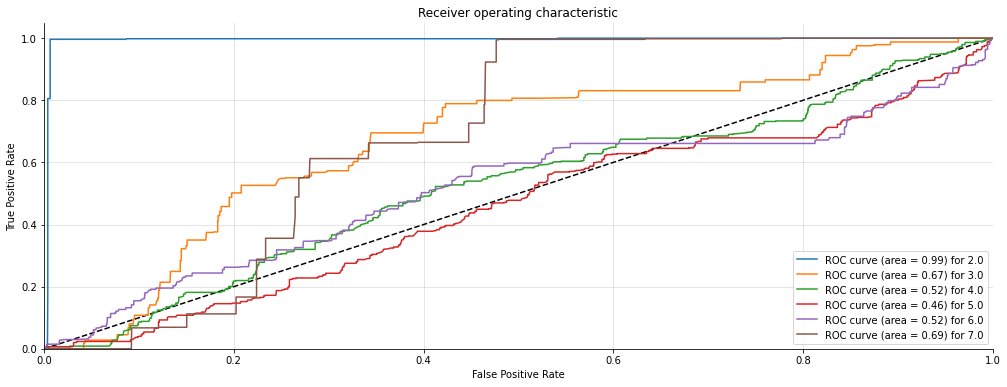

For column: inventive
              precision    recall  f1-score   support

         1.0       0.99      0.48      0.65       545
         2.0       0.45      0.51      0.48       576
         3.0       0.19      0.25      0.21       589
         4.0       0.21      0.11      0.15       586
         5.0       0.23      0.18      0.20       533
         6.0       0.17      0.30      0.22       531

    accuracy                           0.31      3360
   macro avg       0.37      0.31      0.32      3360
weighted avg       0.37      0.31      0.32      3360

Confusion Matrix: 
 [[264 105 101  75   0   0]
 [  0 294  88  44  16 134]
 [  0 127 149  56  77 180]
 [  2  62 161  65  61 235]
 [  0  26 152  30  94 231]
 [  0  35 147  33 157 159]]
Accuracy Score : 0.30505952380952384
Precision Score : 0.37236341060257233
Recall Score : 0.30505952380952384
F1 Score : 0.3170350065424405


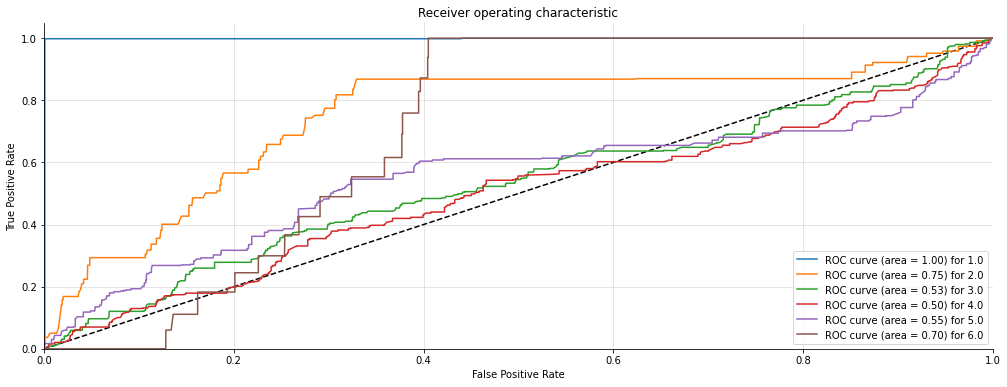

For column: leading edge
              precision    recall  f1-score   support

         1.0       1.00      0.86      0.93       544
         2.0       0.59      0.35      0.44       576
         3.0       0.24      0.16      0.19       582
         4.0       0.26      0.20      0.23       589
         5.0       0.22      0.33      0.26       536
         6.0       0.15      0.26      0.19       533

    accuracy                           0.36      3360
   macro avg       0.41      0.36      0.37      3360
weighted avg       0.41      0.36      0.37      3360

Confusion Matrix: 
 [[469   0   0  75   0   0]
 [  0 201  86  17  99 173]
 [  0  56  94  55 168 209]
 [  0  31  62 117 179 200]
 [  0  20  74  73 176 193]
 [  0  35  71 109 181 137]]
Accuracy Score : 0.35535714285714287
Precision Score : 0.4092153245893927
Recall Score : 0.35535714285714287
F1 Score : 0.3701602165060013


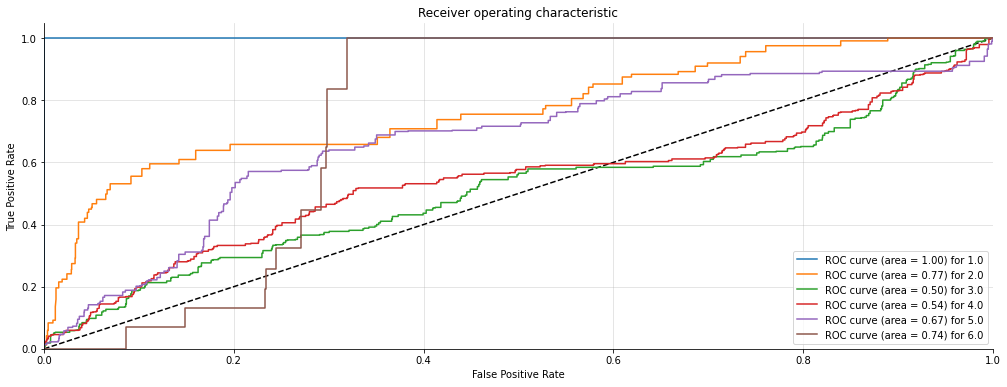

In [ ]:
acc=[]
pre=[]
recal=[]
f1=[]
mae=[]
rms=[]
aucscore=[]
fpo=dict()
tpo=dict()
ffpo=[]
ttpo=[]

clf = AdaBoostClassifier(n_estimators=500)   
plot_all_result_model(clf, X_test, y_train, y_test,
                      ffpo, ttpo)

#### 4.5.3.1. Average AdaBoost ROC

Here we plot the average ROC for each class, found with our AdaBoost.

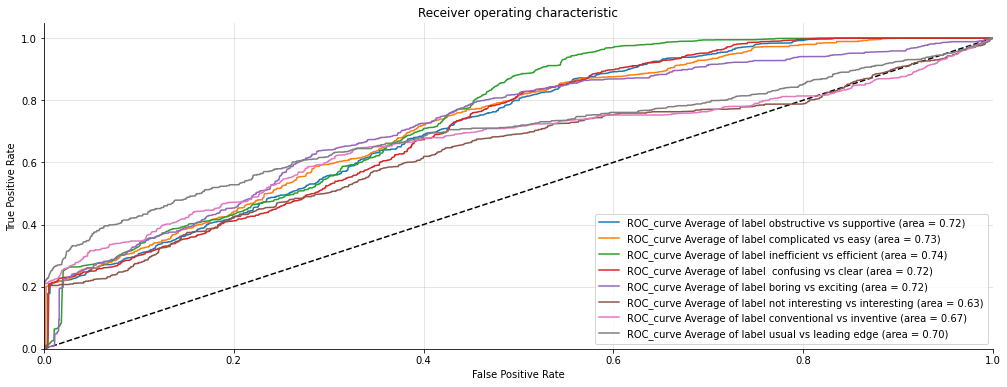

In [ ]:
plot_multiclass_roc_optim(clf, X_train, y_train, X_test, y_test)

In [ ]:
print("Average Accuracy : {}".format(np.mean(acc)))
print("Average Precision : {}".format(np.mean(pre)))
print("Average Recall : {}".format(np.mean(recal)))
print("Average F1-score : {}".format(np.mean(f1)))
print("Average RMSE score : {}".format(np.mean(rms)))
print("Average AUC score : {}".format(np.mean(aucscore)))
metric_df['AdaBoost'] = [np.mean(acc), np.mean(pre),
                         np.mean(recal), np.mean(f1),
                         np.mean(rms), np.mean(aucscore),
                         np.mean(mae)]

Average Accuracy : 0.35695684523809523
Average Precision : 0.4127580072536702
Average Recall : 0.35695684523809523
Average F1-score : 0.3540058684561337
Average RMSE score : 1.616387818911226
Average AUC score : 0.612222885380761


### 4.5.4 Bagging Classfiers

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

For column: supportive
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.96      0.98      0.97       576
         4.0       0.82      0.86      0.84       594
         5.0       0.74      0.68      0.71       571
         6.0       0.73      0.74      0.74       541
         7.0       0.90      0.90      0.90       534

    accuracy                           0.86      3360
   macro avg       0.86      0.86      0.86      3360
weighted avg       0.86      0.86      0.86      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 564  12   0   0   0]
 [  0   6 510  62  15   1]
 [  0   2  59 389 117   4]
 [  0   7  32  53 400  49]
 [  1   5   9  21  15 483]]
Accuracy Score : 0.8598214285714286
Precision Score : 0.858441307890437
Recall Score : 0.8598214285714286
F1 Score : 0.8588250906935916


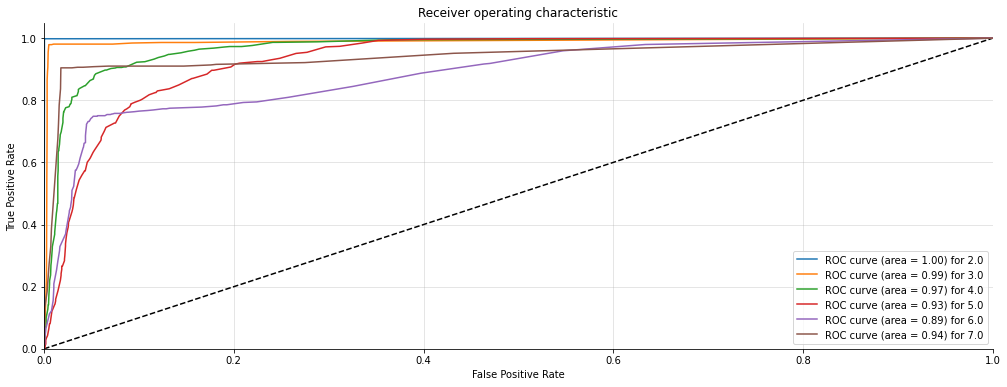

For column: easy
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.96      0.98      0.97       575
         4.0       0.82      0.87      0.84       589
         5.0       0.77      0.71      0.74       573
         6.0       0.81      0.82      0.82       541
         7.0       0.97      0.97      0.97       538

    accuracy                           0.89      3360
   macro avg       0.89      0.89      0.89      3360
weighted avg       0.89      0.89      0.89      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 564  11   0   0   0]
 [  0   3 510  70   6   0]
 [  0   6  62 404  98   3]
 [  0  11  31  41 446  12]
 [  1   0   6   8   3 520]]
Accuracy Score : 0.8889880952380952
Precision Score : 0.888011925541751
Recall Score : 0.8889880952380952
F1 Score : 0.888111129051476


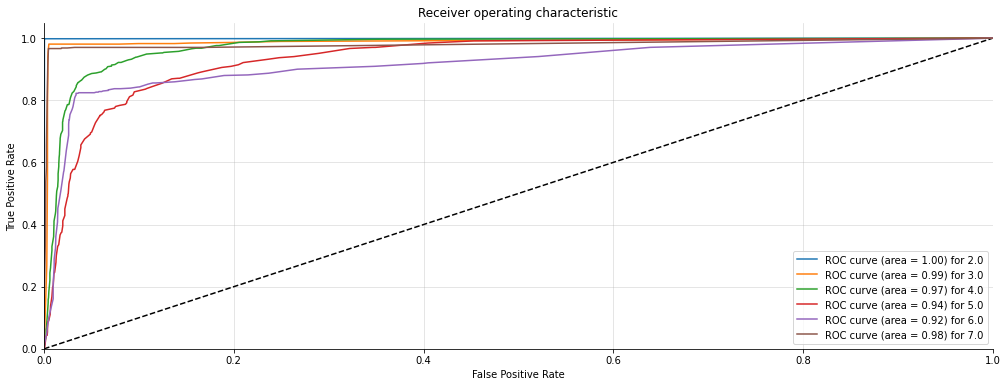

For column: efficient
              precision    recall  f1-score   support

         3.0       1.00      0.81      0.89       670
         4.0       0.66      0.76      0.71       681
         5.0       0.62      0.73      0.67       726
         6.0       0.74      0.72      0.73       639
         7.0       0.97      0.82      0.89       644

    accuracy                           0.77      3360
   macro avg       0.80      0.77      0.78      3360
weighted avg       0.79      0.77      0.78      3360

Confusion Matrix: 
 [[543 127   0   0   0]
 [  0 519 160   2   0]
 [  0 109 533  79   5]
 [  0  18 148 463  10]
 [  1  10  22  80 531]]
Accuracy Score : 0.7705357142857143
Precision Score : 0.7943403895734718
Recall Score : 0.7705357142857143
F1 Score : 0.7775213764212374


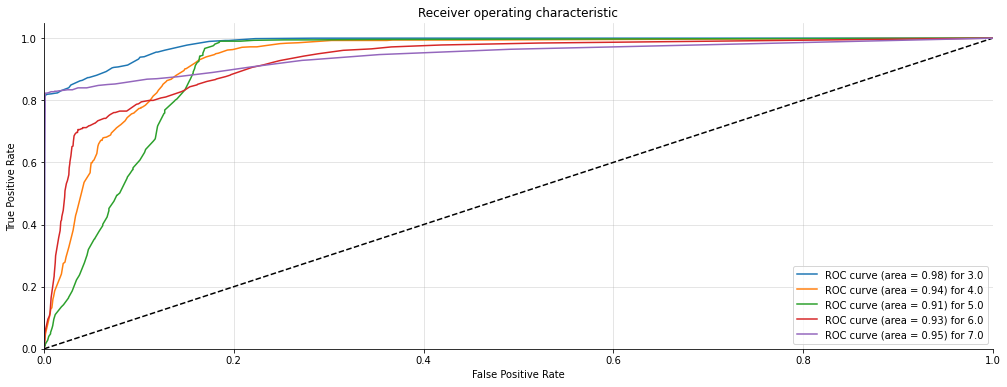

For column: clear
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       544
         3.0       0.97      0.98      0.97       578
         4.0       0.80      0.86      0.83       595
         5.0       0.72      0.66      0.69       567
         6.0       0.74      0.74      0.74       540
         7.0       0.91      0.91      0.91       536

    accuracy                           0.86      3360
   macro avg       0.86      0.86      0.86      3360
weighted avg       0.85      0.86      0.86      3360

Confusion Matrix: 
 [[543   1   0   0   0   0]
 [  0 564  12   2   0   0]
 [  0   4 511  70   9   1]
 [  0   2  64 374 123   4]
 [  1   7  31  58 398  45]
 [  0   5  19  16   9 487]]
Accuracy Score : 0.85625
Precision Score : 0.8547934532860608
Recall Score : 0.85625
F1 Score : 0.8551299733441626


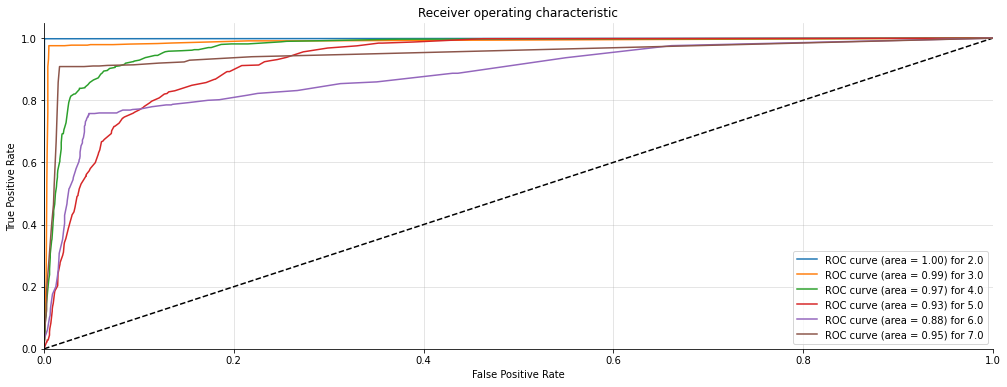

For column: exciting
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       545
         3.0       0.95      0.97      0.96       574
         4.0       0.85      0.85      0.85       572
         5.0       0.86      0.81      0.83       602
         6.0       0.91      0.95      0.93       533
         7.0       0.99      0.99      0.99       534

    accuracy                           0.93      3360
   macro avg       0.93      0.93      0.93      3360
weighted avg       0.92      0.93      0.93      3360

Confusion Matrix: 
 [[543   1   0   1   0   0]
 [  1 558   7   5   3   0]
 [  0  20 487  51  13   1]
 [  0   7  77 489  26   3]
 [  0   0   2  25 504   2]
 [  0   0   0   0   5 529]]
Accuracy Score : 0.9255952380952381
Precision Score : 0.9249453553982382
Recall Score : 0.9255952380952381
F1 Score : 0.925107231026216


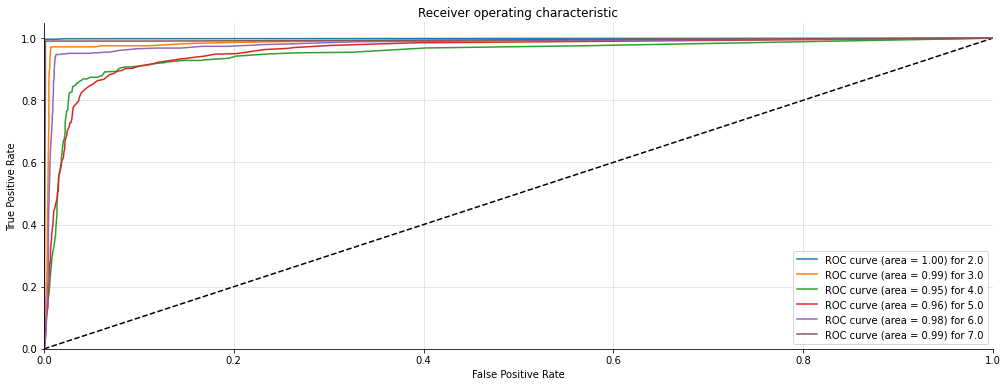

For column: interesting
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       545
         3.0       0.96      0.97      0.97       574
         4.0       0.85      0.88      0.87       578
         5.0       0.88      0.80      0.84       592
         6.0       0.91      0.94      0.93       537
         7.0       0.99      0.99      0.99       534

    accuracy                           0.93      3360
   macro avg       0.93      0.93      0.93      3360
weighted avg       0.93      0.93      0.93      3360

Confusion Matrix: 
 [[543   1   0   0   1   0]
 [  1 558  10   3   2   0]
 [  0  19 511  34  13   1]
 [  0   4  79 473  31   5]
 [  0   0   1  27 507   2]
 [  0   0   0   0   5 529]]
Accuracy Score : 0.9288690476190476
Precision Score : 0.9286632701730821
Recall Score : 0.9288690476190476
F1 Score : 0.9282893240790718


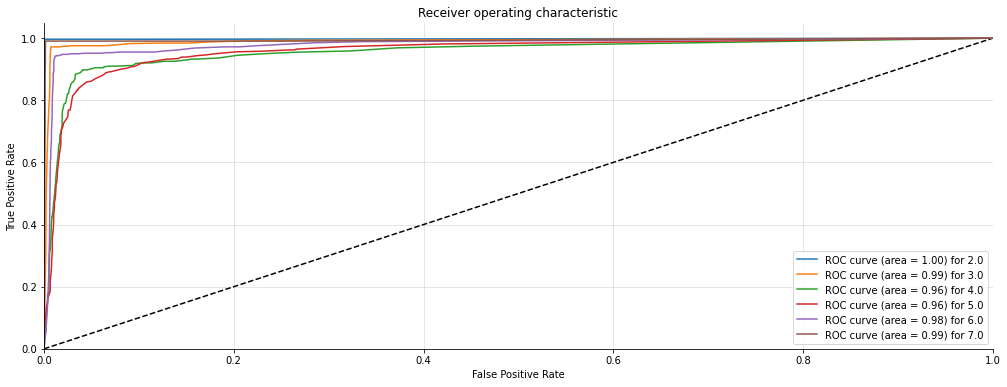

For column: inventive
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       545
         2.0       0.98      1.00      0.99       576
         3.0       0.93      0.92      0.92       589
         4.0       0.92      0.87      0.90       586
         5.0       0.93      0.97      0.95       533
         6.0       0.98      1.00      0.99       531

    accuracy                           0.96      3360
   macro avg       0.96      0.96      0.96      3360
weighted avg       0.96      0.96      0.96      3360

Confusion Matrix: 
 [[544   1   0   0   0   0]
 [  0 574   2   0   0   0]
 [  0   7 539  37   6   0]
 [  0   1  38 512  31   4]
 [  0   0   0   9 517   7]
 [  0   0   0   0   0 531]]
Accuracy Score : 0.9574404761904762
Precision Score : 0.9570639125129632
Recall Score : 0.9574404761904762
F1 Score : 0.9570676479778185


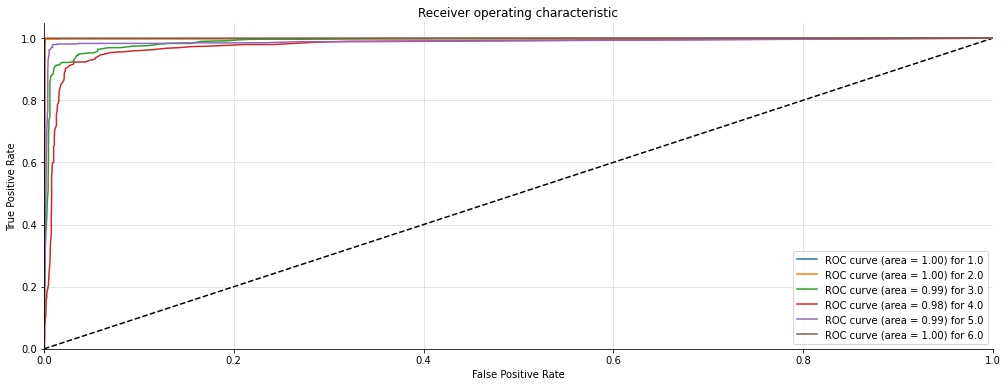

For column: leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       544
         2.0       0.99      1.00      0.99       576
         3.0       0.97      0.98      0.97       582
         4.0       0.98      0.93      0.96       589
         5.0       0.97      1.00      0.99       536
         6.0       1.00      1.00      1.00       533

    accuracy                           0.98      3360
   macro avg       0.98      0.98      0.98      3360
weighted avg       0.98      0.98      0.98      3360

Confusion Matrix: 
 [[544   0   0   0   0   0]
 [  0 576   0   0   0   0]
 [  0   2 568  11   1   0]
 [  0   5  18 549  15   2]
 [  0   0   0   0 536   0]
 [  0   0   0   0   0 533]]
Accuracy Score : 0.9839285714285714
Precision Score : 0.9839608680999867
Recall Score : 0.9839285714285714
F1 Score : 0.9837951934578109


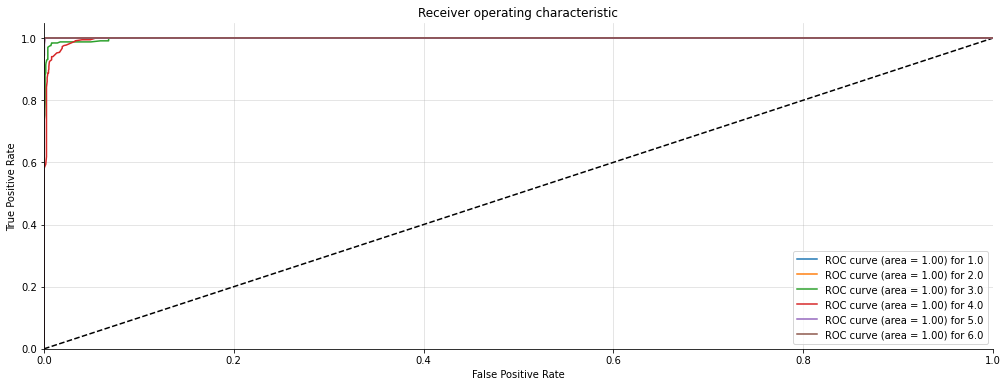

In [ ]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

acc=[]
pre=[]
recal=[]
f1=[]
rms=[]
aucscore=[]
mae=[]
fpo=dict()
tpo=dict()
ffpo=[]
ttpo=[]

clf = BaggingClassifier(KNeighborsClassifier(),
                        max_samples=0.5, max_features=0.5)   

plot_all_result_model(clf, X_test, y_train, y_test,
                      ffpo, ttpo)

#### 4.5.4.1. Average Bagging Classifier ROC

Here we plot the average ROC for each class, found with our Bagging Classifier.

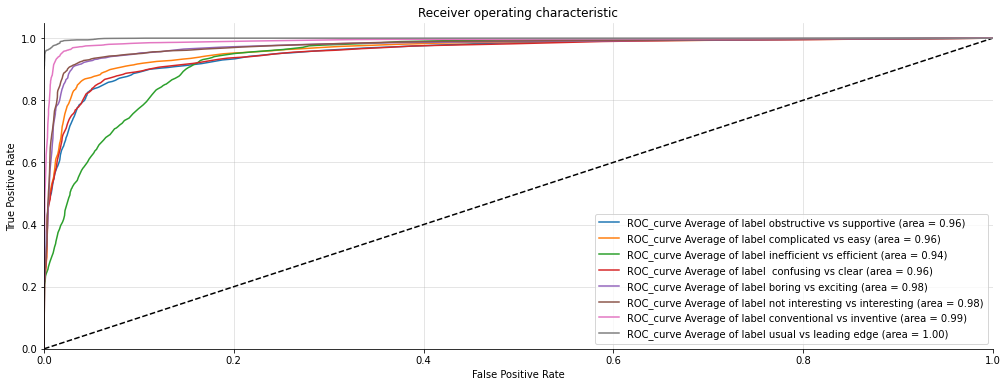

In [ ]:
plot_multiclass_roc_optim(clf  ,X_train, y_train, X_test, y_test)

In [ ]:
print("average Accuracy :{}".format(np.mean(acc)))
print("average Precision :{}".format(np.mean(pre)))
print("average Recall :{}".format(np.mean(recal)))
print("average F1 -score :{}".format(np.mean(f1)))
print("average RMSE {}".format(np.mean(rms)))
print("average AUC score {}".format(np.mean(aucscore)))
metric_df['BaggingClassifier'] = [np.mean(acc), np.mean(pre),
                                  np.mean(recal), np.mean(f1),
                                  np.mean(rms), np.mean(aucscore),
                                  np.mean(mae)]

average Accuracy :0.8964285714285715
average Precision :0.8987775603094988
average Recall :0.8964285714285715
average F1 -score :0.8967308707564231
average RMSE 0.388894940005575
average AUC score 0.936900933815113


#5. Metric Display

In [ ]:
metric_df

Neural Network Classifier       XGB  ...  AdaBoost  BaggingClassifier
metric                                          ...                             
Accuracy                    0.893452  0.811161  ...  0.356957           0.896429
Precision                   0.897508  0.809607  ...  0.412758           0.898778
Recall                      0.893452  0.811161  ...  0.356957           0.896429
F1 Score                    0.894045  0.807459  ...  0.354006           0.896731
RMSE                        0.383763  0.629054  ...  1.616388           0.388895
AUC score                   0.935121  0.885471  ...  0.612223           0.936901
MAE                         0.122693  0.251749  ...  1.171131           0.122879

[7 rows x 12 columns]

In [ ]:
# metric_df.to_csv("final_result.csv") # Uncomment to save as .csv file